In [2]:
import pandas as pd
import numpy as np
import nibabel as nib
import scipy
import statsmodels
import math

from numpy import var
from math import sqrt

import matplotlib.pyplot as plt
import seaborn as sns

import ants
import pickle

from tqdm import tqdm_notebook

import sys

In [3]:
#folder to save outputs
date = '20_10_22'

In [4]:
# upload data

In [5]:
meta_full = pd.read_csv('/csc/epitkane/home/atagmazi/AD_DL_ADNI/metafile_completing/metafile_completed_adni_all_04_10_2022.csv')
abeta_perm = pd.read_csv(date+'/abeta_info_improved_'+date+'.csv')
prediction_test_best = np.load(date+'/abeta_prediction_best_'+date+'.npy',allow_pickle='TRUE')

In [6]:
abeta_perm.shape

(1870, 29)

In [7]:
mni_t1 = ants.image_read('/csc/epitkane/home/atagmazi/Downloads/mni_icbm152_nlin_sym_09a_nifti/mni_icbm152_nlin_sym_09a/mni_icbm152_t1_tal_nlin_sym_09a.nii')

In [54]:
mni = nib.load('/csc/epitkane/home/atagmazi/Downloads/mni_icbm152_nlin_sym_09a_nifti/mni_icbm152_nlin_sym_09a/mni_icbm152_t1_tal_nlin_sym_09a.nii')

In [8]:
brain_labels = pd.read_xml('/csc/epitkane/home/atagmazi/labels_Neuromorphometrics.xml',xpath=".//label")

In [9]:
bm = ants.image_read('/csc/epitkane/home/atagmazi/labels_Neuromorphometrics.nii').astype('uint32')
brain_map =  ants.resample_image_to_target(bm, mni_t1, interp_type='nearestNeighbor').astype('uint32').numpy()

# Prepare brain atlas for further analysis

## Prepare brain areas masks

In [10]:
# preparation of brain areas masks 
brain_areas = np.unique(brain_map)[1:]
area_masks = []
for area in tqdm_notebook(brain_areas):
    area_mask = np.zeros_like(brain_map)
    area_mask[brain_map == area] = 1
    #area_mask = resize_image(area_mask, mni_t1.numpy().shape, interpolation=0)
    area_masks.append(area_mask)
    
#area_names = atlas['labels'][1:]

/tmp/ipykernel_13735/301391891.py:4: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/136 [00:00<?, ?it/s]

In [11]:
brain_labels['name'].values

array(['3rd Ventricle', '4th Ventricle', 'Right Accumbens Area',
       'Left Accumbens Area', 'Right Amygdala', 'Left Amygdala',
       'Brain Stem', 'Right Caudate', 'Left Caudate',
       'Right Cerebellum Exterior', 'Left Cerebellum Exterior',
       'Right Cerebellum White Matter', 'Left Cerebellum White Matter',
       'Right Cerebral White Matter', 'Left Cerebral White Matter', 'CSF',
       'Right Hippocampus', 'Left Hippocampus', 'Right Inf Lat Vent',
       'Left Inf Lat Vent', 'Right Lateral Ventricle',
       'Left Lateral Ventricle', 'Right Pallidum', 'Left Pallidum',
       'Right Putamen', 'Left Putamen', 'Right Thalamus Proper',
       'Left Thalamus Proper', 'Right Ventral DC', 'Left Ventral DC',
       'Right vessel', 'Left vessel', 'Optic Chiasm',
       'Cerebellar Vermal Lobules I-V',
       'Cerebellar Vermal Lobules VI-VII',
       'Cerebellar Vermal Lobules VIII-X', 'Left Basal Forebrain',
       'Right Basal Forebrain', 'Right ACgG anterior cingulate gyrus',
  

In [12]:
range(len(brain_labels['name']))

range(0, 136)

In [13]:
brain_dict = {}
for i in range(len(brain_labels['name'])):
    brain_dict[brain_labels['name'].values[i]] = area_masks[i].copy()

In [14]:
prefered_order = ['3rd Ventricle', '4th Ventricle','Brain Stem','Optic Chiasm',
       #'Cerebellar Vermal Lobules I-V',
       #'Cerebellar Vermal Lobules VI-VII',
       #'Cerebellar Vermal Lobules VIII-X', 
                  'CSF',
                 'Right Accumbens Area', 'Left Accumbens Area',
                  'Right Amygdala', 'Left Amygdala',
                  'Right Caudate','Left Caudate', 
                  'Right Cerebellum Exterior', 'Left Cerebellum Exterior',
                  'Right Cerebellum White Matter', 'Left Cerebellum White Matter',
                  'Right Cerebral White Matter', 'Left Cerebral White Matter',
                  'Right Hippocampus', 'Left Hippocampus',
                  'Right Inf Lat Vent', 'Left Inf Lat Vent',
                  'Right Lateral Ventricle', 'Left Lateral Ventricle',
                  'Right Pallidum', 'Left Pallidum',
                  'Right Putamen', 'Left Putamen',
                  'Right Thalamus Proper', 'Left Thalamus Proper',
                  'Right Ventral DC', 'Left Ventral DC',
                  'Right vessel', 'Left vessel',
                    'Left Basal Forebrain', 'Right Basal Forebrain',
                  'Right ACgG anterior cingulate gyrus', 'Left ACgG anterior cingulate gyrus',
                  'Right AIns anterior insula', 'Left AIns anterior insula',
                  'Right AOrG anterior orbital gyrus', 'Left AOrG anterior orbital gyrus',
                  'Right AnG angular gyrus', 'Left AnG angular gyrus',
                  'Right Calc calcarine cortex', 'Left Calc calcarine cortex', 
                  'Right CO central operculum', 'Left CO central operculum',
                  'Right Cun cuneus', 'Left Cun cuneus',
                  'Right Ent entorhinal area', 'Left Ent entorhinal area',
                  'Right FO frontal operculum', 'Left FO frontal operculum',
                  'Right FRP frontal pole', 'Left FRP frontal pole',
                  'Right FuG fusiform gyrus', 'Left FuG fusiform gyrus', 
                  'Right GRe gyrus rectus', 'Left GRe gyrus rectus',
                  'Right IOG inferior occipital gyrus', 'Left IOG inferior occipital gyrus',
                  'Right ITG inferior temporal gyrus', 'Left ITG inferior temporal gyrus', 
                  'Right LiG lingual gyrus', 'Left LiG lingual gyrus', 
                  'Right LOrG lateral orbital gyrus', 'Left LOrG lateral orbital gyrus', 
                  'Right MCgG middle cingulate gyrus', 'Left MCgG middle cingulate gyrus', 
                  'Right MFC medial frontal cortex', 'Left MFC medial frontal cortex',
                  'Right MFG middle frontal gyrus', 'Left MFG middle frontal gyrus',
                  'Right MOG middle occipital gyrus', 'Left MOG middle occipital gyrus', 
                  'Right MOrG medial orbital gyrus', 'Left MOrG medial orbital gyrus',
                  'Right MPoG postcentral gyrus medial segment', 'Left MPoG postcentral gyrus medial segment',
                  'Right MPrG precentral gyrus medial segment', 'Left MPrG precentral gyrus medial segment',
                  'Right MSFG superior frontal gyrus medial segment', 'Left MSFG superior frontal gyrus medial segment',
                  'Right MTG middle temporal gyrus', 'Left MTG middle temporal gyrus',
                  'Right OCP occipital pole', 'Left OCP occipital pole',
                  'Right OFuG occipital fusiform gyrus', 'Left OFuG occipital fusiform gyrus',
                  'Right OpIFG opercular part of the inferior frontal gyrus','Left OpIFG opercular part of the inferior frontal gyrus',
                  'Right OrIFG orbital part of the inferior frontal gyrus','Left OrIFG orbital part of the inferior frontal gyrus',
                  'Right PCgG posterior cingulate gyrus','Left PCgG posterior cingulate gyrus', 
                  'Right PCu precuneus', 'Left PCu precuneus', 
                  'Right PHG parahippocampal gyrus', 'Left PHG parahippocampal gyrus', 
                  'Right PIns posterior insula', 'Left PIns posterior insula',
                  'Right PO parietal operculum', 'Left PO parietal operculum', 
                  'Right PoG postcentral gyrus', 'Left PoG postcentral gyrus',
                  'Right POrG posterior orbital gyrus', 'Left POrG posterior orbital gyrus',
                  'Right PP planum polare', 'Left PP planum polare',
                  'Right PrG precentral gyrus', 'Left PrG precentral gyrus',
                  'Right PT planum temporale', 'Left PT planum temporale',
                  'Right SCA subcallosal area', 'Left SCA subcallosal area',
                  'Right SFG superior frontal gyrus', 'Left SFG superior frontal gyrus',
                  'Right SMC supplementary motor cortex', 'Left SMC supplementary motor cortex',
                  'Right SMG supramarginal gyrus', 'Left SMG supramarginal gyrus',
                  'Right SOG superior occipital gyrus', 'Left SOG superior occipital gyrus',
                  'Right SPL superior parietal lobule', 'Left SPL superior parietal lobule',
                  'Right STG superior temporal gyrus', 'Left STG superior temporal gyrus',
                  'Right TMP temporal pole', 'Left TMP temporal pole',
                  'Right TrIFG triangular part of the inferior frontal gyrus',
                  'Left TrIFG triangular part of the inferior frontal gyrus',
                  'Right TTG transverse temporal gyrus','Left TTG transverse temporal gyrus']

In [15]:
len(brain_labels['name'])

136

In [16]:
len(prefered_order)

133

In [17]:
brain_dict_ordered = {}
for i in range(len(prefered_order)):
    brain_dict_ordered[prefered_order[i]] = brain_dict[prefered_order[i]]

In [19]:
# merge right and left hemisphere masks
brain_dict_merged = {}
for i in range(0,5):
    brain_dict_merged[prefered_order[i]] = brain_dict_ordered[prefered_order[i]]
for i in range(5,len(prefered_order),2):
    brain_dict_merged[prefered_order[i][5:]] = brain_dict_ordered[prefered_order[i]] + brain_dict_ordered[prefered_order[i+1]]
        

In [358]:
len(brain_dict_merged.keys())

77

In [21]:
# create more global masks for grey matter and cortex lobes
grey_matter_mask = np.zeros_like(brain_map)

frontal_lobe_mask = np.zeros_like(brain_map)
parietal_lobe_mask = np.zeros_like(brain_map)
occipital_lobe_mask = np.zeros_like(brain_map)
temporal_lobe_mask = np.zeros_like(brain_map)
limbic_lobe_mask = np.zeros_like(brain_map)
ventricles_mask = np.zeros_like(brain_map)
subcortical_mask = np.zeros_like(brain_map)


gm_keys = [' ACgG anterior cingulate gyrus', ' AIns anterior insula', ' AOrG anterior orbital gyrus', 
                  ' AnG angular gyrus', ' Calc calcarine cortex', ' CO central operculum', ' Cun cuneus',
                  ' Ent entorhinal area', ' FO frontal operculum', ' FRP frontal pole', ' FuG fusiform gyrus',
                  ' GRe gyrus rectus', ' IOG inferior occipital gyrus', ' ITG inferior temporal gyrus', ' LiG lingual gyrus',
                  ' LOrG lateral orbital gyrus', ' MCgG middle cingulate gyrus', ' MFC medial frontal cortex',
                  ' MFG middle frontal gyrus', ' MOG middle occipital gyrus', ' MOrG medial orbital gyrus',
                  ' MPoG postcentral gyrus medial segment', ' MPrG precentral gyrus medial segment', 
                  ' MSFG superior frontal gyrus medial segment', ' MTG middle temporal gyrus', ' OCP occipital pole', 
                  ' OFuG occipital fusiform gyrus', ' OpIFG opercular part of the inferior frontal gyrus', 
                  ' OrIFG orbital part of the inferior frontal gyrus', ' PCgG posterior cingulate gyrus', 
                  ' PCu precuneus', ' PHG parahippocampal gyrus', ' PIns posterior insula', ' PO parietal operculum',
                  ' PoG postcentral gyrus', ' POrG posterior orbital gyrus', ' PP planum polare', ' PrG precentral gyrus', 
                  ' PT planum temporale', ' SCA subcallosal area', ' SFG superior frontal gyrus', 
                  ' SMC supplementary motor cortex', ' SMG supramarginal gyrus', ' SOG superior occipital gyrus',
                  ' SPL superior parietal lobule', ' STG superior temporal gyrus', ' TMP temporal pole',
                  ' TrIFG triangular part of the inferior frontal gyrus', ' TTG transverse temporal gyrus']
# Not sure about: anterior insula, central operculum, fusiform gyrus (inbeetwen), middle cingulate gyrus,occipital fusiform gyrus,
# posterior insula, subcallosal area, entorhinal area
frontal_lobe_keys = [' AOrG anterior orbital gyrus',' FO frontal operculum',
                    ' FRP frontal pole',' GRe gyrus rectus',' LOrG lateral orbital gyrus',' MFC medial frontal cortex',
                    ' MFG middle frontal gyrus',' MOrG medial orbital gyrus',' MPrG precentral gyrus medial segment',
                    ' MSFG superior frontal gyrus medial segment', ' OpIFG opercular part of the inferior frontal gyrus',
                    ' OrIFG orbital part of the inferior frontal gyrus', ' POrG posterior orbital gyrus',
                    ' PrG precentral gyrus',' SFG superior frontal gyrus', ' SMC supplementary motor cortex',
                     ' TrIFG triangular part of the inferior frontal gyrus',' AIns anterior insula']

parietal_lobe_keys = [' AnG angular gyrus',' MPoG postcentral gyrus medial segment',
                     ' PCu precuneus', ' PO parietal operculum', ' PoG postcentral gyrus', ' SMG supramarginal gyrus',
                     ' SPL superior parietal lobule',' CO central operculum', ' PIns posterior insula']

occipital_lobe_keys = [' Calc calcarine cortex',' Cun cuneus',' IOG inferior occipital gyrus', ' LiG lingual gyrus',
                      ' MOG middle occipital gyrus',' OCP occipital pole', ' SOG superior occipital gyrus',
                      ' OFuG occipital fusiform gyrus']

temporal_lobe_keys = [' ITG inferior temporal gyrus', ' MTG middle temporal gyrus',
                     ' PP planum polare', ' PT planum temporale', ' STG superior temporal gyrus',
                     ' TMP temporal pole', ' TTG transverse temporal gyrus',' FuG fusiform gyrus']

limbic_lobe_keys = [' ACgG anterior cingulate gyrus',' MCgG middle cingulate gyrus',' PCgG posterior cingulate gyrus',
                    ' SCA subcallosal area', ' PHG parahippocampal gyrus',
                    ' Ent entorhinal area']
ventricles_keys = ['3rd Ventricle', '4th Ventricle', 'CSF',' Inf Lat Vent', ' Lateral Ventricle']
subcortical_keys = [ ' Accumbens Area', ' Amygdala', ' Caudate',' Hippocampus', 
                    ' Pallidum', ' Putamen', ' Thalamus Proper',' Ventral DC']

for key in gm_keys:
    grey_matter_mask = grey_matter_mask + brain_dict_merged.get(key)


for key in frontal_lobe_keys:
    frontal_lobe_mask = frontal_lobe_mask + brain_dict_merged.get(key)

for key in parietal_lobe_keys:
    parietal_lobe_mask = parietal_lobe_mask + brain_dict_merged.get(key)

for key in occipital_lobe_keys:
    occipital_lobe_mask = occipital_lobe_mask + brain_dict_merged.get(key)

for key in temporal_lobe_keys:
    temporal_lobe_mask = temporal_lobe_mask + brain_dict_merged.get(key)

for key in limbic_lobe_keys:
    limbic_lobe_mask = limbic_lobe_mask + brain_dict_merged.get(key)
    
for key in ventricles_keys:
    ventricles_mask = ventricles_mask + brain_dict_merged.get(key)
    
for key in subcortical_keys:
    subcortical_mask = subcortical_mask + brain_dict_merged.get(key)

In [22]:
brain_dict_merged['Cortical grey matter'] = grey_matter_mask
brain_dict_merged['Frontal lobe'] = frontal_lobe_mask
brain_dict_merged['Parietal lobe'] = parietal_lobe_mask
brain_dict_merged['Occipital lobe'] = occipital_lobe_mask
brain_dict_merged['Temporal lobe'] = temporal_lobe_mask
brain_dict_merged['Limbic lobe'] = limbic_lobe_mask
brain_dict_merged['Ventricles'] = ventricles_mask
brain_dict_merged['Subcortical'] = subcortical_mask

In [ ]:
with open('brain_atlas_merged.pkl', 'wb') as f:
    pickle.dump(brain_dict_merged, f)

(-0.5, 232.5, 188.5, -0.5)

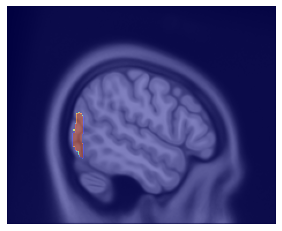

In [23]:
plt.imshow(np.rot90(mni_t1[45, :, :].copy()), cmap = 'gray')
plt.imshow(np.rot90(occipital_lobe_mask[45, :, :].copy()), cmap = 'jet',alpha = 0.5) 
plt.axis('off')

(-0.5, 232.5, 188.5, -0.5)

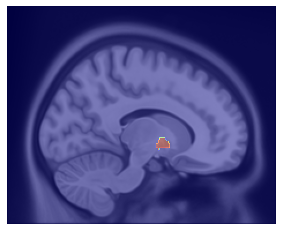

In [24]:
plt.imshow(np.rot90(mni_t1[85, :, :].copy()), cmap = 'gray')
plt.imshow(np.rot90(brain_dict_merged[' Pallidum'][85, :, :].copy()), cmap = 'jet',alpha = 0.5) 
plt.axis('off')

(-0.5, 196.5, 188.5, -0.5)

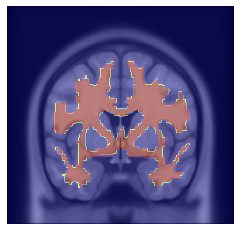

In [24]:
plt.imshow(np.rot90(mni_t1[:, 135, :].copy()), cmap = 'gray')
plt.imshow(np.rot90(brain_dict_merged[' Cerebral White Matter'][:, 135, :].copy()), cmap = 'jet',alpha = 0.5) 
plt.axis('off')

In [25]:
list(brain_dict_merged.keys())

['3rd Ventricle',
 '4th Ventricle',
 'Brain Stem',
 'Optic Chiasm',
 'CSF',
 ' Accumbens Area',
 ' Amygdala',
 ' Caudate',
 ' Cerebellum Exterior',
 ' Cerebellum White Matter',
 ' Cerebral White Matter',
 ' Hippocampus',
 ' Inf Lat Vent',
 ' Lateral Ventricle',
 ' Pallidum',
 ' Putamen',
 ' Thalamus Proper',
 ' Ventral DC',
 ' vessel',
 'Basal Forebrain',
 ' ACgG anterior cingulate gyrus',
 ' AIns anterior insula',
 ' AOrG anterior orbital gyrus',
 ' AnG angular gyrus',
 ' Calc calcarine cortex',
 ' CO central operculum',
 ' Cun cuneus',
 ' Ent entorhinal area',
 ' FO frontal operculum',
 ' FRP frontal pole',
 ' FuG fusiform gyrus',
 ' GRe gyrus rectus',
 ' IOG inferior occipital gyrus',
 ' ITG inferior temporal gyrus',
 ' LiG lingual gyrus',
 ' LOrG lateral orbital gyrus',
 ' MCgG middle cingulate gyrus',
 ' MFC medial frontal cortex',
 ' MFG middle frontal gyrus',
 ' MOG middle occipital gyrus',
 ' MOrG medial orbital gyrus',
 ' MPoG postcentral gyrus medial segment',
 ' MPrG precent

# Create arrays of ID for different classes

In [26]:
# create arrays with scans ID of different classes
id_ad = abeta_perm['Image_id'].loc[abeta_perm['Research.Group'] == 'AD'].values
id_mci = abeta_perm['Image_id'].loc[abeta_perm['Research.Group'].isin(['MCI','LMCI','EMCI'])].values
id_cn = abeta_perm['Image_id'].loc[abeta_perm['Research.Group'] == 'CN'].values
id_smc = abeta_perm['Image_id'].loc[abeta_perm['Research.Group'] == 'SMC'].values

bioid0 = abeta_perm['Image_id'].loc[abeta_perm['CLASS'] == 0].values
bioid1 = abeta_perm['Image_id'].loc[abeta_perm['CLASS']== 1].values
bioid2 = abeta_perm['Image_id'].loc[abeta_perm['CLASS'] == 2].values
bioid3 = abeta_perm['Image_id'].loc[abeta_perm['CLASS'] == 3].values

id_apos = abeta_perm['Image_id'].loc[abeta_perm['CLASS'].isin([2,3])].values
id_aneg = abeta_perm['Image_id'].loc[abeta_perm['CLASS'].isin([0,1])].values

In [859]:
id_cn

array(['I1043793', 'I1022851', 'I401876', 'I1174703', 'I508687',
       'I1214755', 'I206549', 'I405683', 'I240246', 'I405473', 'I242625',
       'I943072', 'I1079398', 'I468016', 'I260467', 'I253198', 'I1015909',
       'I287358', 'I238692', 'I1335724', 'I437152', 'I262715', 'I285211',
       'I288953', 'I1063363', 'I389656', 'I255201', 'I303319', 'I278426',
       'I1148998', 'I257495', 'I274050', 'I396007', 'I358496', 'I1301238',
       'I1005479', 'I319761', 'I202529', 'I277006', 'I313020', 'I247743',
       'I965144', 'I966237', 'I252773', 'I1080069', 'I504666', 'I1286103',
       'I856453', 'I1097404', 'I199423', 'I503885', 'I1037770', 'I998648',
       'I1034060', 'I1322527', 'I614509', 'I1044850', 'I1067418',
       'I619348', 'I1286964', 'I1043805', 'I877236', 'I192554', 'I243616',
       'I940863', 'I1045306', 'I995813', 'I556819', 'I1017085', 'I718410',
       'I250306', 'I266090', 'I192558', 'I957707', 'I1049565', 'I398066',
       'I385561', 'I255934', 'I283668', 'I385875'

# Calculating relevance values for regions of all samples and average maps
##### !!!Run only on cluster!!!

In [ ]:
#upload gradient values from files
with open('wrap_grad_all.pkl', 'rb') as f:
    wrap_grad_all = pickle.load(f)
    
with open('wrap_pet_all.pkl', 'rb') as f:
    wrap_pet_all = pickle.load(f)

In [ ]:
print('data uploaded')

In [195]:
len(brain_dict_merged)

72

In [42]:
#functionas for finding an average gradient map for samples in the same class
def average_map(id_list, map_list):
    avg_relevance_map = np.zeros([197, 233, 189],dtype = 'float64')
    number = 0
    for i in range(len(id_list)):
        if id_list[i] in list(map_list.keys()):
            x = map_list[id_list[i]]
            avg_relevance_map = np.add(avg_relevance_map,x)
            #avg_relevance_map += x
            number += 1
    avg_relevance_map = avg_relevance_map/number
    #avg_relevance_map /= number
    return(avg_relevance_map)


# function for finding relevance value per area
def get_relevance_per_area(relevance_map):
    relevances = np.zeros(len(brain_dict_merged))
    for i, area_mask in enumerate(brain_dict_merged):
        relevances[i] = np.sum(relevance_map * brain_dict_merged[area_mask])/np.sum(brain_dict_merged[area_mask])


    # use average instead for comparing between regions and summary to compare between groups
    # Merge left and right areas.
    #merged_relevances = np.concatenate([relevances[:2],relevances[2:].reshape(-1, 2).sum(1)])

    #return sorted(zip(merged_area_names, merged_relevances*100),key = lambda a:a[1],reverse=True)
    return sorted(zip(list(brain_dict_merged.keys()), relevances),key = lambda a:a[1],reverse=True)


def get_relevance_per_area_nosorting(relevance_map):
    relevances = np.zeros(len(brain_dict_merged))
    for i, area_mask in enumerate(brain_dict_merged):
        relevances[i] = np.sum(relevance_map * brain_dict_merged[area_mask])/np.sum(brain_dict_merged[area_mask])

    return(relevances)


'def get_relevance_per_area(relevance_map, normalize=True):\n    relevances = np.zeros(len(area_masks))\n    for i, area_mask in enumerate(area_masks):\n        relevances[i] = np.sum(relevance_map * area_mask)/np.sum(area_mask)\n    if normalize:\n        relevances /= relevances.sum()  # make all areas sum to 1\n\n    # use average instead for comparing between regions and summary to compare between groups\n    # Merge left and right areas.\n    merged_relevances = np.concatenate([relevances[:2],relevances[2:].reshape(-1, 2).sum(1)])\n\n    #return sorted(zip(merged_area_names, merged_relevances*100),key = lambda a:a[1],reverse=True)\n    return sorted(zip(merged_area_names, merged_relevances),key = lambda a:a[1],reverse=True)'

In [ ]:
# Gradients
#dataframe of relevance areas for all samples
#creating and saving grad dataframe where columns - image id; raws - brain areas; 
#cells - corresponding relevant value

relevence_values_grad = pd.DataFrame(index = brain_dict_merged.keys())

for i in wrap_grad_all.keys():
    x = get_relevance_per_area_nosorting(wrap_grad_all[i])
    
    relevence_values_grad[i] = x

relevence_values_grad.to_csv(date+'/relevence_values_grad_'+date+'.csv')
print('relevence_values_grad saved')

In [ ]:
# PET
#dataframe of amyloid concentration for all samples
#creating and saving dataframe where columns - image id; raws - brain areas; 
#cells - corresponding amyloid concentration

abeta_concentration_pet = pd.DataFrame(index = brain_dict_merged.keys())

for i in wrap_pet_all.keys():
    x = get_relevance_per_area_nosorting(wrap_pet_all[i])
    
    abeta_concentration_pet[i] = x

abeta_concentration_pet.to_csv(date+'/abeta_concentration_pet_'+date+'.csv')
print('abeta_concentration_pet saved')

In [ ]:
# Relevance from gradients
relevance_map = dict()
relevance_value = dict()

# dictionary with all average grad maps for all classes
total_map = average_map(abeta_perm['Image_id'].values,wrap_grad_all)

ad_map = average_map(id_ad,wrap_grad_all)
mci_map = average_map(id_mci,wrap_grad_all)
cn_map = average_map(id_cn,wrap_grad_all)
smc_map = average_map(id_smc,wrap_grad_all)

bio0_map = average_map(bioid0,wrap_grad_all)
bio1_map = average_map(bioid1,wrap_grad_all)
bio2_map = average_map(bioid2,wrap_grad_all)
bio3_map = average_map(bioid3,wrap_grad_all)

apos_map = average_map(id_apos,wrap_grad_all)
aneg_map = average_map(id_aneg,wrap_grad_all)


relevance_map['total_map'] = total_map

relevance_map['ad_map'] = ad_map
relevance_map['mci_map'] = mci_map
relevance_map['cn_map'] = cn_map
relevance_map['smc_map'] = smc_map

relevance_map['bio0_map'] = bio0_map
relevance_map['bio1_map'] = bio1_map
relevance_map['bio2_map'] = bio2_map
relevance_map['bio3_map'] = bio3_map

relevance_map['apos_map'] = apos_map
relevance_map['aneg_map'] = aneg_map

#ditionary with average relevance values for brain areas in all classes
relevance_value['total'] = get_relevance_per_area(total_map)

relevance_value['ad'] = get_relevance_per_area(ad_map)
relevance_value['mci'] = get_relevance_per_area(mci_map)
relevance_value['cn'] = get_relevance_per_area(cn_map)
relevance_value['smc'] = get_relevance_per_area(smc_map)

relevance_value['bio0'] = get_relevance_per_area(bio0_map)
relevance_value['bio1'] = get_relevance_per_area(bio1_map)
relevance_value['bio2'] = get_relevance_per_area(bio2_map)
relevance_value['bio3'] = get_relevance_per_area(bio3_map)

relevance_value['apos'] = get_relevance_per_area(apos_map)
relevance_value['aneg'] = get_relevance_per_area(aneg_map)

In [ ]:
#Abeta concentration from PET
abeta_concentration_map = dict()
abeta_concentration_value = dict()

# dictionary with all average grad maps for all classes
total_map = average_map(abeta_perm['Image_id'].values,wrap_pet_all)

ad_map = average_map(id_ad,wrap_pet_all)
mci_map = average_map(id_mci,wrap_pet_all)
cn_map = average_map(id_cn,wrap_pet_all)
smc_map = average_map(id_smc,wrap_pet_all)

bio0_map = average_map(bioid0,wrap_pet_all)
bio1_map = average_map(bioid1,wrap_pet_all)
bio2_map = average_map(bioid2,wrap_pet_all)
bio3_map = average_map(bioid3,wrap_pet_all)

apos_map = average_map(id_apos,wrap_pet_all)
aneg_map = average_map(id_aneg,wrap_pet_all)


abeta_concentration_map['total_map'] = total_map

abeta_concentration_map['ad_map'] = ad_map
abeta_concentration_map['mci_map'] = mci_map
abeta_concentration_map['cn_map'] = cn_map
abeta_concentration_map['smc_map'] = smc_map

abeta_concentration_map['bio0_map'] = bio0_map
abeta_concentration_map['bio1_map'] = bio1_map
abeta_concentration_map['bio2_map'] = bio2_map
abeta_concentration_map['bio3_map'] = bio3_map

abeta_concentration_map['apos_map'] = apos_map
abeta_concentration_map['aneg_map'] = aneg_map

#ditionary with average relevance values for brain areas in all classes
abeta_concentration_value['total'] = get_relevance_per_area(total_map)

abeta_concentration_value['ad'] = get_relevance_per_area(ad_map)
abeta_concentration_value['mci'] = get_relevance_per_area(mci_map)
abeta_concentration_value['cn'] = get_relevance_per_area(cn_map)
abeta_concentration_value['smc'] = get_relevance_per_area(smc_map)

abeta_concentration_value['bio0'] = get_relevance_per_area(bio0_map)
abeta_concentration_value['bio1'] = get_relevance_per_area(bio1_map)
abeta_concentration_value['bio2'] = get_relevance_per_area(bio2_map)
abeta_concentration_value['bio3'] = get_relevance_per_area(bio3_map)

abeta_concentration_value['apos'] = get_relevance_per_area(apos_map)
abeta_concentration_value['aneg'] = get_relevance_per_area(aneg_map)

In [31]:
#save them
with open(date+'/relevance_map.pkl', 'wb') as f:
    pickle.dump(relevance_map, f)
    
with open(date+'/relevance_value.pkl', 'wb') as f:
    pickle.dump(relevance_value, f)
    
    
with open(date+'/abeta_concentration_map.pkl', 'wb') as f:
    pickle.dump(abeta_concentration_map, f)
    
with open(date+'/abeta_concentration_value.pkl', 'wb') as f:
    pickle.dump(abeta_concentration_value, f)

NameError: name 'relevance_map' is not defined

In [ ]:
print('done')

In [25]:
sys.exit()

SystemExit: 

/csc/epitkane/home/atagmazi/.conda/envs/atagmazi_gpu5/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3465: UserWarning:

To exit: use 'exit', 'quit', or Ctrl-D.



# Data analysis 
###### Can be run in Jupyter notebook

In [28]:
# Upload files
##!!!!! check dates
with open('20_10_22/relevance_map.pkl', 'rb') as f:
    relevance_map = pickle.load(f)
    
with open('20_10_22/relevance_value.pkl', 'rb') as f:
    relevance_value = pickle.load(f)
    
relevence_values_grad = pd.read_csv(date+'/relevence_values_grad_'+date+'.csv', index_col = 0)

with open('20_10_22/abeta_concentration_map.pkl', 'rb') as f:
    abeta_concentration_map = pickle.load(f)
    
with open('20_10_22/abeta_concentration_value.pkl', 'rb') as f:
    abeta_concentration_value = pickle.load(f)
    
abeta_concentration_pet = pd.read_csv(date+'/abeta_concentration_pet_'+date+'.csv', index_col = 0)

In [29]:
relevance_value

{'total': [(' Pallidum', 0.00025168403331759473),
  (' Cerebellum White Matter', 0.00025079569752213077),
  (' Cerebral White Matter', 0.00020673819237006206),
  (' Ventral DC', 0.00016203748234357192),
  (' SPL superior parietal lobule', 0.0001521001140853203),
  (' SOG superior occipital gyrus', 0.00014395083948034855),
  ('Brain Stem', 0.00013428301576658345),
  (' OCP occipital pole', 0.00013237205618706253),
  (' Thalamus Proper', 0.0001319665595955362),
  (' AnG angular gyrus', 0.00012841945439959852),
  (' Accumbens Area', 0.00012568254797343673),
  (' MTG middle temporal gyrus', 0.0001245783363621737),
  (' MOG middle occipital gyrus', 0.00012276849336054037),
  (' FRP frontal pole', 0.00011945496506078889),
  (' ITG inferior temporal gyrus', 0.00011845522512823091),
  (' MFG middle frontal gyrus', 0.00011192184214978018),
  (' SMG supramarginal gyrus', 0.00011185313976052031),
  ('Subcortical', 0.0001115002936020857),
  (' PoG postcentral gyrus', 0.00011046045598353076),
  (' 

In [30]:
relevence_values_grad

I308131       I403540   I430472   I401876   I245839  \
3rd Ventricle   0.000013  6.750633e-06  0.000017  0.000010 -0.000016   
4th Ventricle   0.000040  2.229461e-05  0.000014  0.000014  0.000092   
Brain Stem      0.000224  1.317908e-04  0.000143  0.000144  0.000165   
Optic Chiasm    0.000068  4.722202e-06  0.000009  0.000028  0.000026   
CSF             0.000019  6.655136e-06  0.000004  0.000022  0.000054   
...                  ...           ...       ...       ...       ...   
Occipital lobe  0.000107  1.201969e-04  0.000098  0.000098  0.000135   
Temporal lobe   0.000128  1.384585e-04  0.000137  0.000100  0.000094   
Limbic lobe     0.000069  3.966050e-05  0.000041  0.000057  0.000084   
Ventricles      0.000011  1.591269e-07  0.000008  0.000026  0.000121   
Subcortical     0.000132  1.052242e-04  0.000100  0.000106  0.000190   

                 I508687   I349208   I345759       I356080   I365180  ...  \
3rd Ventricle   0.000006  0.000007  0.000011  1.420234e-05  0.000012  ...   
4th Ventricle   0.000007  0.000036  0.000020  1.850744e-05  0.000036  ...   
Brain Stem      0.000149  0.000096  0.000144  1.111750e-04  0.000099  ...   
Optic Chiasm    0.000006  0.000014  0.000022  1.246276e-05  0.000005  ...   
CSF             0.000011  0.000006  0.000008  2.236889e-07  0.000027  ...   
...                  ...       ...       ...           ...       ...  ...   
Occipital lobe  0.000093  0.000140  0.000094  7.872899e-05  0.000107  ...   
Temporal lobe   0.000103  0.000141  0.000135  6.656799e-05  0.000147  ...   
Limbic lobe     0.000051  0.000043  0.000032  4.148638e-05  0.000040  ...   
Ventricles      0.000015  0.000023  0.000014 -2.716172e-06  0.000029  ...   
Subcortical     0.000112  0.000099  0.000092  1.104023e-04  0.000146  ...   

                 I208927   I261308   I401864   I525008   I497671   I235432  \
3rd Ventricle   0.000018  0.000015  0.000011  0.000017  0.000009  0.000012   
4th Ventricle   0.000014  0.000013  0.000011  0.000017  0.000013  0.000010   
Brain Stem      0.000203  0.000157  0.000152  0.000124  0.000155  0.000127   
Optic Chiasm    0.000041  0.000013  0.000003  0.000010  0.000015 -0.000006   
CSF             0.000006  0.000009  0.000007  0.000013  0.000019  0.000012   
...                  ...       ...       ...       ...       ...       ...   
Occipital lobe  0.000137  0.000078  0.000076  0.000104  0.000072  0.000075   
Temporal lobe   0.000155  0.000074  0.000087  0.000144  0.000083  0.000070   
Limbic lobe     0.000046  0.000047  0.000035  0.000040  0.000046  0.000031   
Ventricles     -0.000001 -0.000002  0.000005  0.000007  0.000004 -0.000007   
Subcortical     0.000148  0.000133  0.000103  0.000107  0.000118  0.000077   

                 I206414   I392844   I207682   I297099  
3rd Ventricle   0.000008  0.000009  0.000057  0.000015  
4th Ventricle   0.000018  0.000028  0.000024  0.000028  
Brain Stem      0.000107  0.000141  0.000157  0.000153  
Optic Chiasm    0.000028  0.000013  0.000006  0.000009  
CSF             0.000012  0.000011  0.000037  0.000012  
...                  ...       ...       ...       ...  
Occipital lobe  0.000083  0.000122  0.000121  0.000084  
Temporal lobe   0.000089  0.000184  0.000102  0.000115  
Limbic lobe     0.000038  0.000041  0.000080  0.000043  
Ventricles      0.000003  0.000022  0.000034  0.000018  
Subcortical     0.000082  0.000093  0.000132  0.000110  

[77 rows x 1390 columns]

In [31]:
abeta_concentration_pet

I308131   I403540   I430472   I401876   I245839   I508687  \
3rd Ventricle   0.814105  0.679740  0.995429  0.752954  0.434430  0.635590   
4th Ventricle   1.102221  1.198774  0.896914  1.052833  1.085723  0.844900   
Brain Stem      1.570262  1.927267  1.690247  1.687801  1.339853  1.976690   
Optic Chiasm    0.930303  0.600288  0.725770  0.754270  0.617922  0.863529   
CSF             0.790803  0.572644  0.906073  0.838399  0.904422  0.756099   
...                  ...       ...       ...       ...       ...       ...   
Occipital lobe  1.562598  1.870120  1.406062  1.281131  1.132840  1.396531   
Temporal lobe   1.397937  1.794197  1.420356  1.253014  1.107642  1.262843   
Limbic lobe     1.331109  1.788517  1.440740  1.176789  0.906681  1.289839   
Ventricles      0.714871  0.687865  1.003645  0.910031  1.064930  0.663431   
Subcortical     1.344933  1.651744  1.572674  1.407902  1.245094  1.598795   

                 I349208   I345759   I356080   I365180  ...   I208927  \
3rd Ventricle   0.704467  1.077962  0.576226  1.189065  ...  0.636884   
4th Ventricle   1.203255  1.116149  0.946227  1.360775  ...  1.009594   
Brain Stem      1.615571  1.996759  1.396402  2.090815  ...  1.842076   
Optic Chiasm    1.008717  0.813868  0.638365  0.986442  ...  0.811681   
CSF             0.709490  0.996119  0.496460  1.190904  ...  0.569667   
...                  ...       ...       ...       ...  ...       ...   
Occipital lobe  2.088536  1.896262  1.126257  2.241472  ...  1.739005   
Temporal lobe   1.966150  1.763777  1.004344  2.090214  ...  1.569379   
Limbic lobe     1.866650  1.748562  0.942715  2.062060  ...  1.389923   
Ventricles      1.050932  1.096784  0.571017  1.223703  ...  0.623744   
Subcortical     1.703097  1.847575  1.087666  2.157699  ...  1.543764   

                 I261308   I401864   I525008   I497671   I235432   I206414  \
3rd Ventricle   0.565234  0.632576  1.080231  0.703798  0.662576  0.829437   
4th Ventricle   0.802659  0.833724  0.986991  0.746906  0.798666  1.032206   
Brain Stem      1.423165  1.587242  1.836502  1.650952  1.486344  1.636457   
Optic Chiasm    0.611080  0.596564  0.783551  0.667057  0.565791  1.045142   
CSF             0.585579  0.654748  0.757162  0.716477  0.673730  0.671709   
...                  ...       ...       ...       ...       ...       ...   
Occipital lobe  1.088841  1.170222  1.868725  1.170657  1.195970  1.291749   
Temporal lobe   0.998486  1.095016  1.725445  1.073421  1.092063  1.229490   
Limbic lobe     0.931927  1.005409  1.533766  1.059325  0.981059  1.173478   
Ventricles      0.548268  0.700460  0.845140  0.641511  0.606491  0.684427   
Subcortical     1.178011  1.311745  1.750280  1.338341  1.231692  1.362730   

                 I392844   I207682   I297099  
3rd Ventricle   0.995483  0.805575  0.933290  
4th Ventricle   1.190690  0.932472  1.282078  
Brain Stem      1.702510  1.617818  2.030268  
Optic Chiasm    0.927978  0.673508  0.858467  
CSF             0.910926  0.867409  0.879953  
...                  ...       ...       ...  
Occipital lobe  1.909724  1.352655  1.515113  
Temporal lobe   1.899148  1.372701  1.422985  
Limbic lobe     1.818041  1.360147  1.399653  
Ventricles      1.098462  0.931930  0.952498  
Subcortical     1.696963  1.415806  1.714947  

[77 rows x 1390 columns]

In [32]:
abeta_concentration_value

{'total': [(' Cerebral White Matter', 1.9160372986620102),
  (' Pallidum', 1.8918177786452086),
  (' Cerebellum White Matter', 1.7873539558926699),
  ('Brain Stem', 1.6732623287480466),
  (' Ventral DC', 1.601227221012021),
  (' Putamen', 1.5947183266224194),
  (' IOG inferior occipital gyrus', 1.5499744355368554),
  (' SOG superior occipital gyrus', 1.518007340019773),
  (' AOrG anterior orbital gyrus', 1.5129511522344123),
  (' SFG superior frontal gyrus', 1.512530591924963),
  (' SPL superior parietal lobule', 1.5116927420386255),
  (' PrG precentral gyrus', 1.5090792604639574),
  (' AnG angular gyrus', 1.5074765264788008),
  (' MOG middle occipital gyrus', 1.5060858349187245),
  (' OCP occipital pole', 1.496669676057406),
  (' MFG middle frontal gyrus', 1.4824901683088914),
  (' TrIFG triangular part of the inferior frontal gyrus', 1.47738062400507),
  ('Subcortical', 1.4762981638489217),
  (' LOrG lateral orbital gyrus', 1.4668321521887546),
  (' MTG middle temporal gyrus', 1.4621

## Define subsets of brain regions

In [287]:
# Grad
# creating different subset of brain areas
# Grey matter all together
global_areas = relevence_values_grad.loc[[
 'Brain Stem',
 'Optic Chiasm',
 ' Cerebellum Exterior',
 ' Cerebellum White Matter',
 ' Cerebral White Matter',
    'Cortical grey matter',
'Subcortical',
'Ventricles',' vessel','Basal Forebrain']]
# Grey matter splitted into lobes
local_areas = relevence_values_grad.loc[['Brain Stem',
 'Optic Chiasm',
 ' Cerebellum Exterior',
 ' Cerebellum White Matter',
 ' Cerebral White Matter',
'Subcortical','Basal Forebrain',
'Ventricles',' vessel','Temporal lobe','Parietal lobe','Occipital lobe',
                                       'Frontal lobe', 'Limbic lobe']]
local_hip_areas = relevence_values_grad.loc[['Brain Stem',
 'Optic Chiasm',
 ' Cerebellum Exterior',
 ' Cerebellum White Matter',
 ' Cerebral White Matter',
'Subcortical','Basal Forebrain',
'Ventricles',' vessel','Temporal lobe','Parietal lobe','Occipital lobe',
                                       'Frontal lobe', 'Limbic lobe',' Hippocampus']]
# Grey area splitted into many small areas
detailed_areas = relevence_values_grad[~relevence_values_grad.index.isin(['Cortical grey matter','Temporal lobe','Parietal lobe','Occipital lobe',
                                       'Frontal lobe', 'Limbic lobe'])]

#Grey matter only
gm_only_areas = detailed_areas.loc[[' ACgG anterior cingulate gyrus', ' AIns anterior insula', ' AOrG anterior orbital gyrus', 
                  ' AnG angular gyrus', ' Calc calcarine cortex', ' CO central operculum', ' Cun cuneus',
                  ' Ent entorhinal area', ' FO frontal operculum', ' FRP frontal pole', ' FuG fusiform gyrus',
                  ' GRe gyrus rectus', ' IOG inferior occipital gyrus', ' ITG inferior temporal gyrus', ' LiG lingual gyrus',
                  ' LOrG lateral orbital gyrus', ' MCgG middle cingulate gyrus', ' MFC medial frontal cortex',
                  ' MFG middle frontal gyrus', ' MOG middle occipital gyrus', ' MOrG medial orbital gyrus',
                  ' MPoG postcentral gyrus medial segment', ' MPrG precentral gyrus medial segment', 
                  ' MSFG superior frontal gyrus medial segment', ' MTG middle temporal gyrus', ' OCP occipital pole', 
                  ' OFuG occipital fusiform gyrus', ' OpIFG opercular part of the inferior frontal gyrus', 
                  ' OrIFG orbital part of the inferior frontal gyrus', ' PCgG posterior cingulate gyrus', 
                  ' PCu precuneus', ' PHG parahippocampal gyrus', ' PIns posterior insula', ' PO parietal operculum',
                  ' PoG postcentral gyrus', ' POrG posterior orbital gyrus', ' PP planum polare', ' PrG precentral gyrus', 
                  ' PT planum temporale', ' SCA subcallosal area', ' SFG superior frontal gyrus', 
                  ' SMC supplementary motor cortex', ' SMG supramarginal gyrus', ' SOG superior occipital gyrus',
                  ' SPL superior parietal lobule', ' STG superior temporal gyrus', ' TMP temporal pole',
                  ' TrIFG triangular part of the inferior frontal gyrus', ' TTG transverse temporal gyrus']]

In [288]:
#PET
local_areas_pet = abeta_concentration_pet.loc[['Brain Stem',
 'Optic Chiasm',
 ' Cerebellum Exterior',
 ' Cerebellum White Matter',
 ' Cerebral White Matter',
'Subcortical','Basal Forebrain',
'Ventricles',' vessel','Temporal lobe','Parietal lobe','Occipital lobe',
                                       'Frontal lobe', 'Limbic lobe'#,' Hippocampus'
                                              ]]

## Clustering of local areas based on all samples data

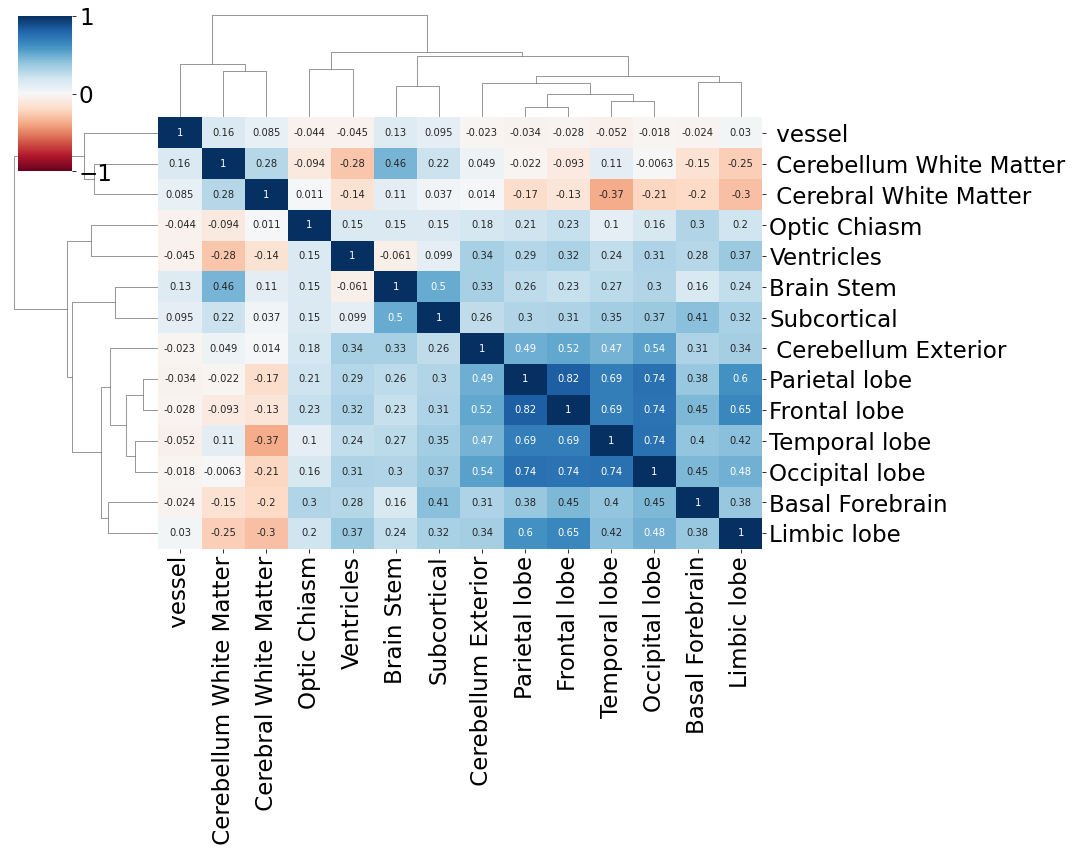

In [290]:
#clustering of local areas based on all samples data
correlations = local_areas.T.corr()
fig = sns.clustermap(correlations, method="complete", cmap='RdBu', annot=True, 
               annot_kws={"size": 10}, vmin=-1, vmax=1, figsize=(15,12))
fig.savefig(date+'/local_areas_heatmap_'+date+'.png')
fig.savefig(date+'/local_areas_heatmap_'+date+'.svg', format="svg")

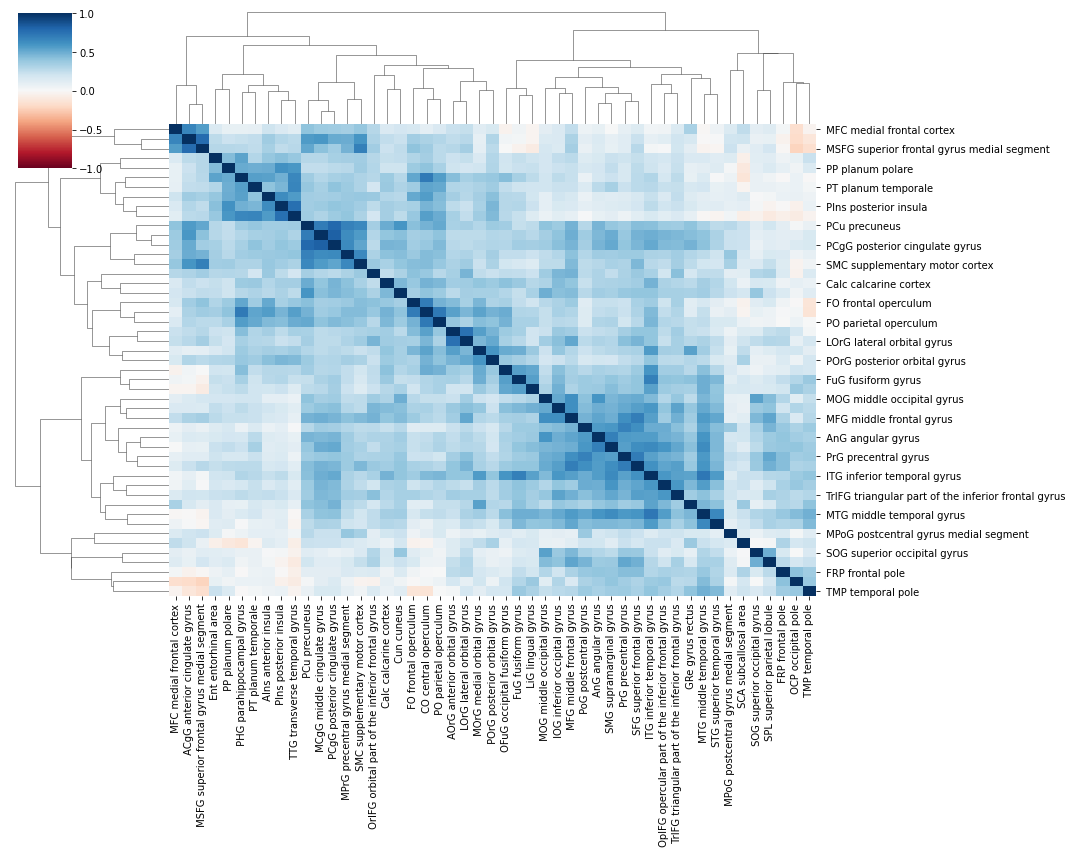

In [102]:
correlations = gm_only_areas.T.corr()
fig = sns.clustermap(correlations, method="complete", cmap='RdBu', annot=False, 
               annot_kws={"size": 5}, vmin=-1, vmax=1, figsize=(15,12))

## Visualisation of average PET scan for all samples

In [226]:
abeta_concentration_map['total_map']

array([[[-3.45140740e-03, -3.91047303e-03, -4.64985901e-03, ...,
         -3.79103221e-04, -1.56246470e-04, -1.13429031e-04],
        [-3.38760168e-03, -3.82294186e-03, -4.52436965e-03, ...,
         -5.94955776e-04, -1.51493524e-04, -4.95207152e-05],
        [-3.27627740e-03, -3.61042977e-03, -4.48296934e-03, ...,
         -5.52042283e-04, -1.36167404e-04, -4.74321149e-05],
        ...,
        [ 2.52104499e-03,  2.75755416e-03,  2.91161618e-03, ...,
         -1.38340965e-04, -1.38516184e-04, -1.46884698e-07],
        [ 2.11480747e-03,  2.38151470e-03,  2.58661880e-03, ...,
         -4.06412248e-08, -2.63622719e-07, -2.52728077e-07],
        [ 2.07763655e-03,  2.33943311e-03,  2.51104917e-03, ...,
          2.19580235e-08, -2.72077722e-07, -2.75242631e-07]],

       [[-3.27887437e-03, -3.86653735e-03, -4.64535533e-03, ...,
         -3.82375062e-04, -1.55465239e-04, -1.19276404e-04],
        [-3.16167751e-03, -3.73651279e-03, -4.40972276e-03, ...,
         -5.92431890e-04, -1.48616285e

In [237]:
cmap = plt.cm.get_cmap('jet')
sm = plt.cm.ScalarMappable( norm=None, cmap=cmap )
flat = abeta_concentration_map['total_map'].reshape( -1 )  # a view
rgba = sm.to_rgba( flat, bytes=True, norm=False ).reshape( abeta_concentration_map['total_map'].shape + (4,) )

In [281]:
np.min(relevance_map['total_map'])

-0.00024372295741082706

In [282]:
np.max(relevance_map['total_map'])

0.0015267111164608996

/tmp/ipykernel_13735/51269259.py:27: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



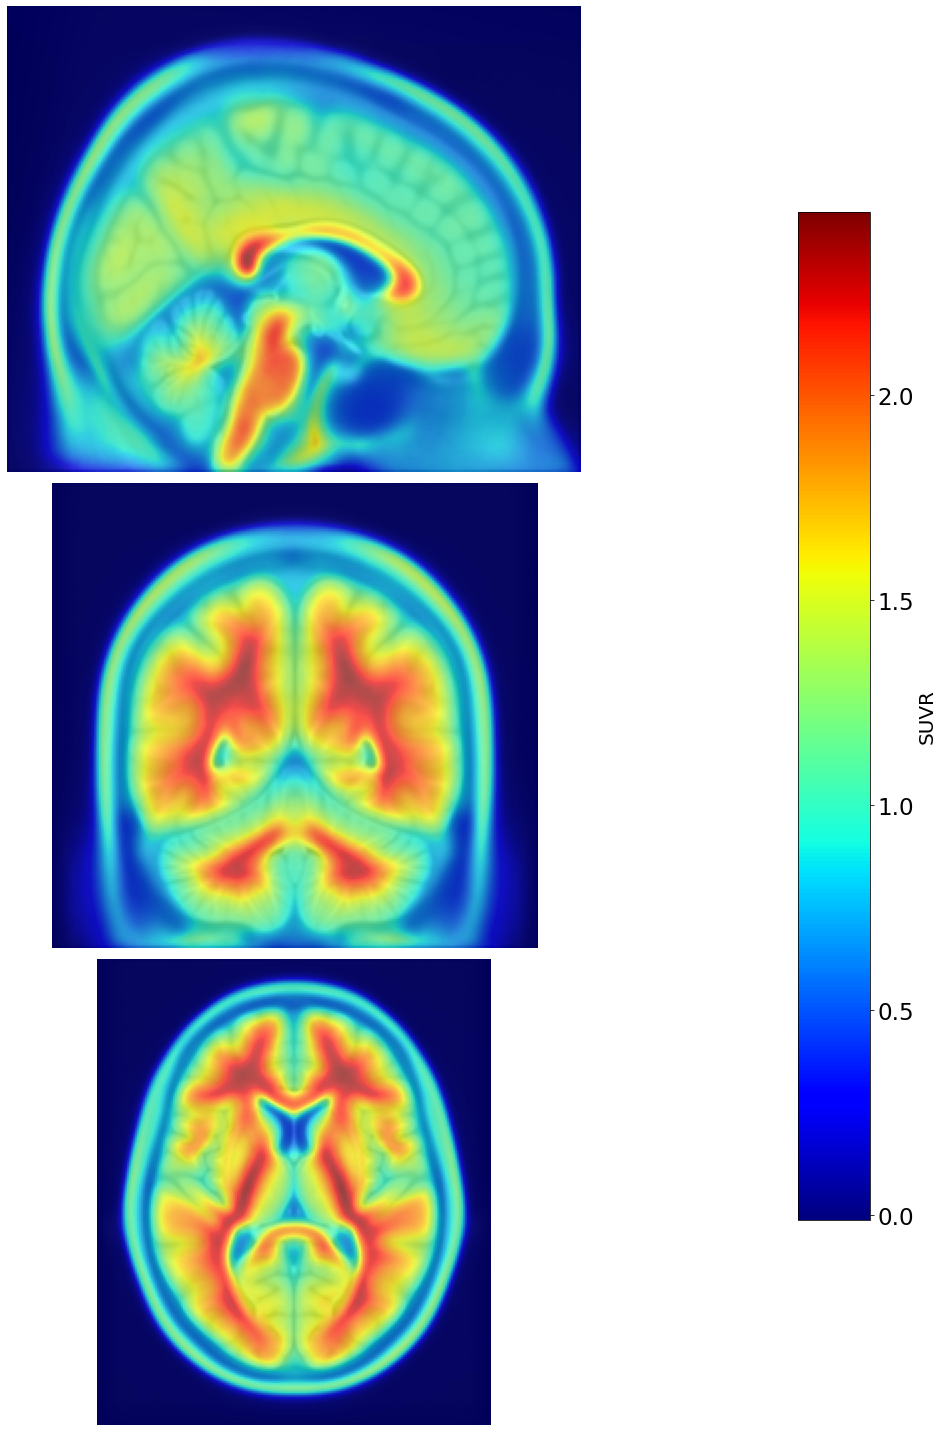

In [317]:
import matplotlib as mpl
fig, axes = plt.subplots(3,1, figsize=(20,20))

axes[0].imshow(np.rot90(mni_t1[100, :, :].copy()), cmap = 'gray')
axes[0].imshow(np.rot90(abeta_concentration_map['total_map'][100, :, :].copy()), cmap = 'jet',alpha = 0.7) 
axes[0].axis('off')

axes[1].imshow(np.rot90(mni_t1[:, 80, :].copy()), cmap = 'gray')
axes[1].imshow(np.rot90(abeta_concentration_map['total_map'][:, 80, :].copy()), cmap = 'jet',alpha = 0.7) 
axes[1].axis('off')

axes[2].imshow(np.rot90(mni_t1[:, :, 80].copy()), cmap = 'gray')
axes[2].imshow(np.rot90(abeta_concentration_map['total_map'][:, :, 80].copy()), cmap = 'jet',alpha = 0.7) 
axes[2].axis('off')

cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#fig.colorbar(im, cax=cbar_ax)
cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=np.min(abeta_concentration_map['total_map']),
                            vmax=np.max(abeta_concentration_map['total_map']))

cb1 = mpl.colorbar.ColorbarBase(ax = cbar_ax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('SUVR',size = 20 )

fig.tight_layout()

fig.savefig(date+'/total_pet_'+date+'.png')
fig.savefig(date+'/total_pet_'+date+'.svg', format="svg",facecolor=fig.get_facecolor())

/tmp/ipykernel_13735/1440215437.py:27: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



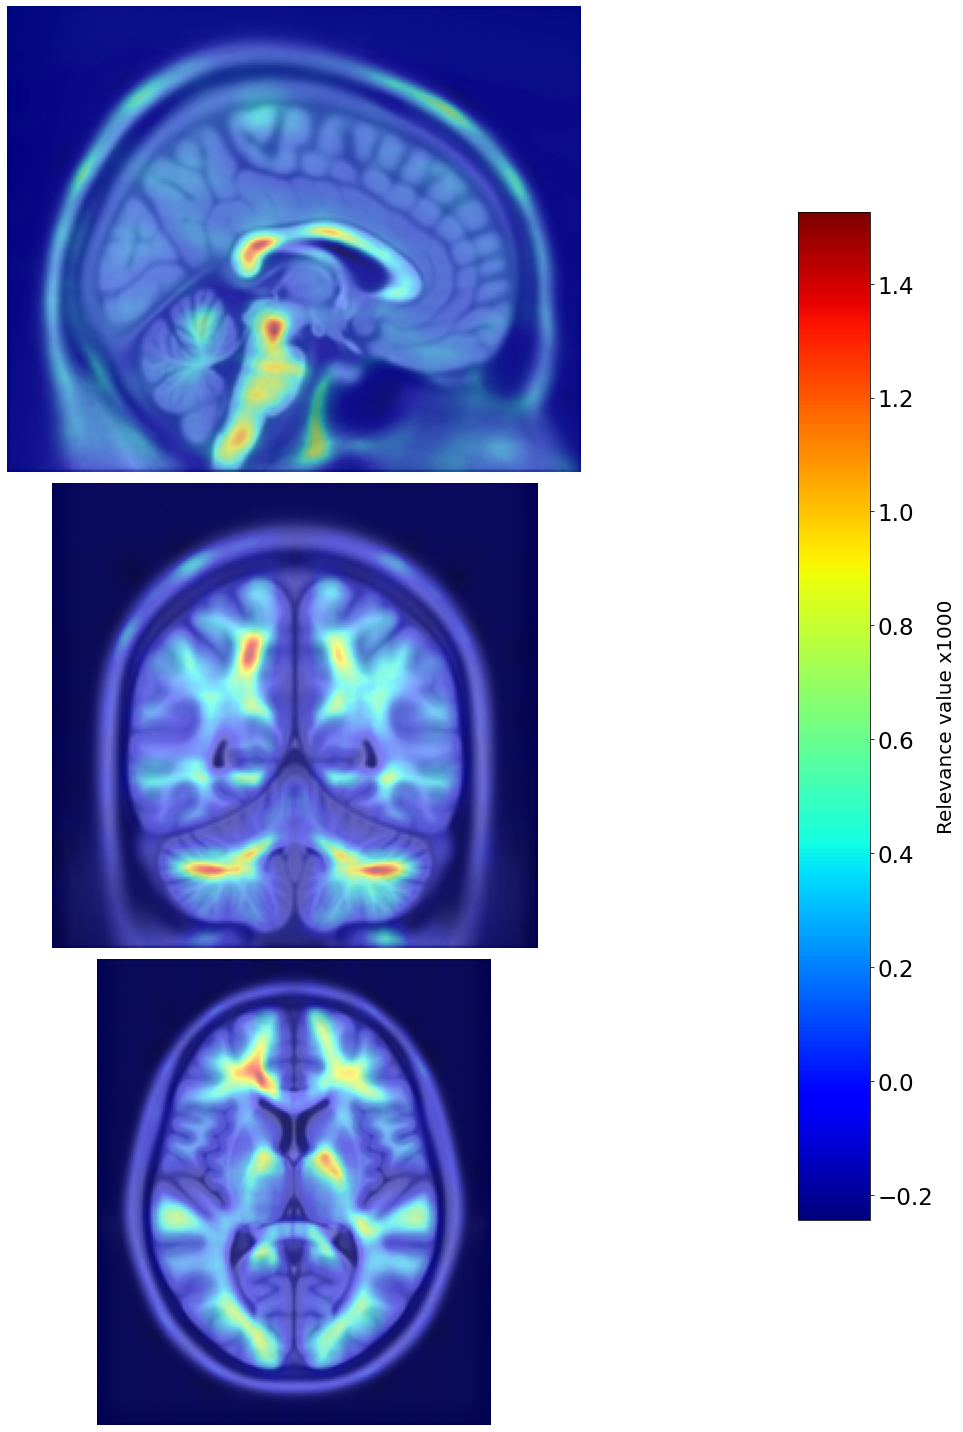

In [301]:
import matplotlib as mpl
fig, axes = plt.subplots(3,1, figsize=(20,20))

axes[0].imshow(np.rot90(mni_t1[100, :, :].copy()), cmap = 'gray')
axes[0].imshow(np.rot90(relevance_map['total_map'][100, :, :].copy())*1000, cmap = 'jet',alpha = 0.5) 
axes[0].axis('off')

axes[1].imshow(np.rot90(mni_t1[:, 80, :].copy()), cmap = 'gray')
axes[1].imshow(np.rot90(relevance_map['total_map'][:, 80, :].copy())*1000, cmap = 'jet',alpha = 0.5) 
axes[1].axis('off')

axes[2].imshow(np.rot90(mni_t1[:, :, 80].copy()), cmap = 'gray')
axes[2].imshow(np.rot90(relevance_map['total_map'][:, :, 80].copy())*1000, cmap = 'jet',alpha = 0.5) 
axes[2].axis('off')

cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#fig.colorbar(im, cax=cbar_ax)
cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=np.min(relevance_map['total_map'])*1000,
                            vmax=np.max(relevance_map['total_map'])*1000)

cb1 = mpl.colorbar.ColorbarBase(ax = cbar_ax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('Relevance value x1000',size = 20 )

fig.tight_layout()

fig.savefig(date+'/total_relval_plot_'+date+'.png')
fig.savefig(date+'/total_relval_plot_'+date+'.svg', format="svg",facecolor=fig.get_facecolor())

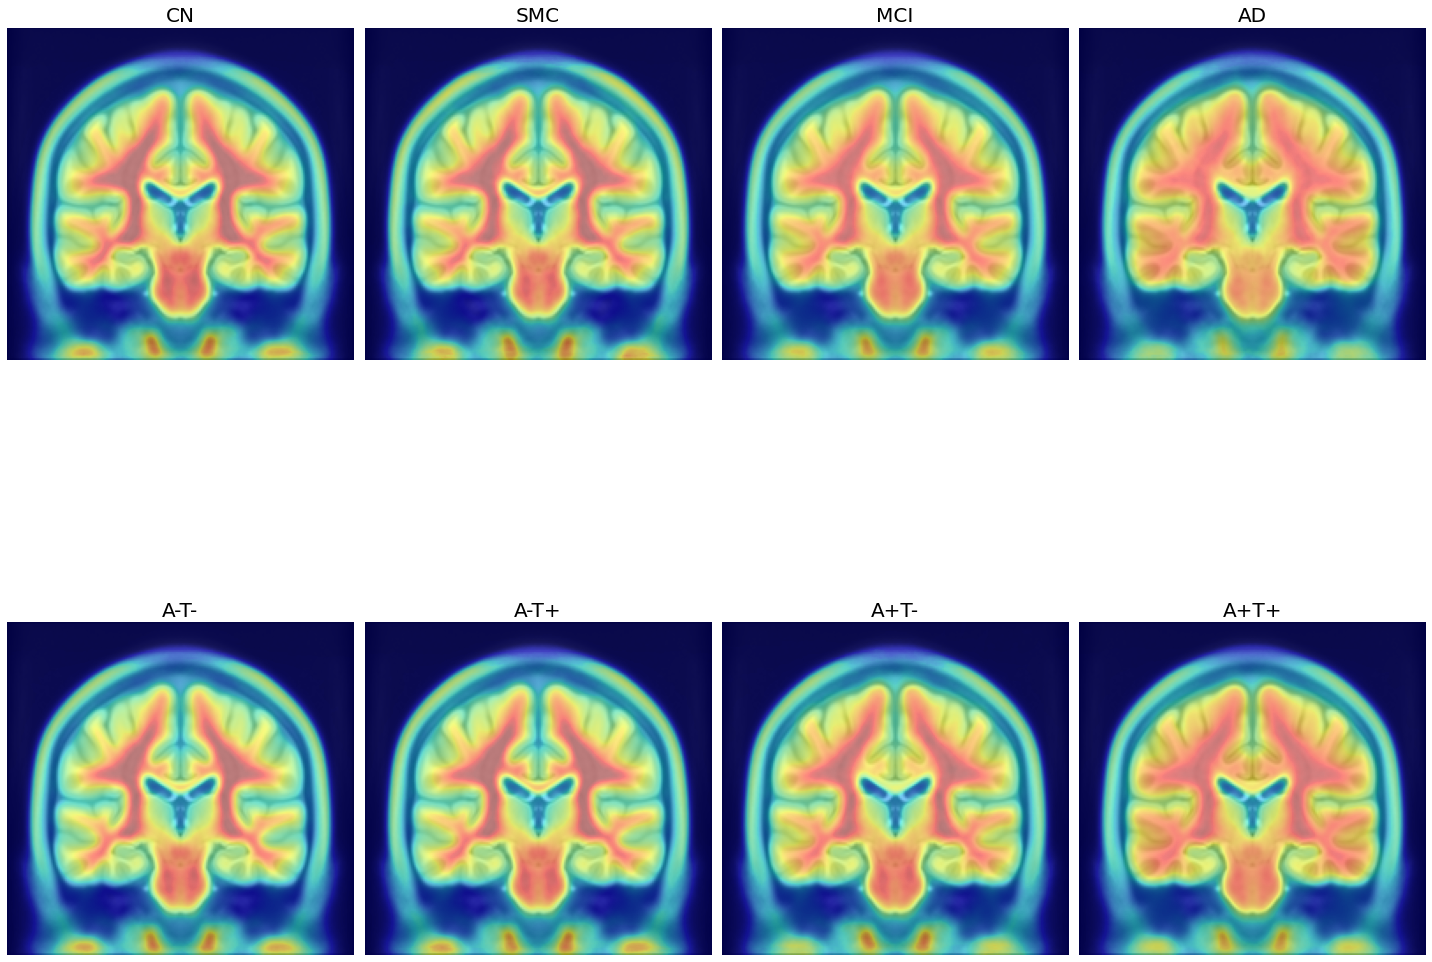

In [36]:
fig, axes = plt.subplots(2,4, figsize=(20,20))

axes[0,0].imshow(np.rot90(mni_t1[:, 110, :].copy()), cmap = 'gray')
axes[0,0].imshow(np.rot90(abeta_concentration_map['cn_map'][:, 110, :].copy()), cmap = 'jet',alpha = 0.5,
          vmin = np.min([abeta_concentration_map['ad_map'],abeta_concentration_map['mci_map'],
       abeta_concentration_map['smc_map'],abeta_concentration_map['cn_map']]),
        vmax = np.quantile([abeta_concentration_map['ad_map'],abeta_concentration_map['mci_map'],
       abeta_concentration_map['smc_map'],abeta_concentration_map['cn_map']],0.999)) 
axes[0,0].axis('off')
axes[0,0].set_title('CN', size = 20)

axes[0,1].imshow(np.rot90(mni_t1[:, 110, :].copy()), cmap = 'gray')
axes[0,1].imshow(np.rot90(abeta_concentration_map['smc_map'][:, 110, :].copy()), cmap = 'jet',alpha = 0.5,
          vmin = np.min([abeta_concentration_map['ad_map'],abeta_concentration_map['mci_map'],
       abeta_concentration_map['smc_map'],abeta_concentration_map['cn_map']]),
        vmax = np.quantile([abeta_concentration_map['ad_map'],abeta_concentration_map['mci_map'],
       abeta_concentration_map['smc_map'],abeta_concentration_map['cn_map']],0.999)) 
axes[0,1].axis('off')
axes[0,1].set_title('SMC', size = 20)

axes[0,2].imshow(np.rot90(mni_t1[:, 110, :].copy()), cmap = 'gray')
axes[0,2].imshow(np.rot90(abeta_concentration_map['mci_map'][:, 110, :].copy()), cmap = 'jet',alpha = 0.5,
          vmin = np.min([abeta_concentration_map['ad_map'],abeta_concentration_map['mci_map'],
       abeta_concentration_map['smc_map'],abeta_concentration_map['cn_map']]),
        vmax = np.quantile([abeta_concentration_map['ad_map'],abeta_concentration_map['mci_map'],
       abeta_concentration_map['smc_map'],abeta_concentration_map['cn_map']],0.999)) 
axes[0,2].axis('off')
axes[0,2].set_title('MCI', size = 20)

axes[0,3].imshow(np.rot90(mni_t1[:, 110, :].copy()), cmap = 'gray')
axes[0,3].imshow(np.rot90(abeta_concentration_map['ad_map'][:, 110, :].copy()), cmap = 'jet',alpha = 0.5,
          vmin = np.min([abeta_concentration_map['ad_map'],abeta_concentration_map['mci_map'],
       abeta_concentration_map['smc_map'],abeta_concentration_map['cn_map']]),
        vmax = np.quantile([abeta_concentration_map['ad_map'],abeta_concentration_map['mci_map'],
       abeta_concentration_map['smc_map'],abeta_concentration_map['cn_map']],0.999)) 
axes[0,3].axis('off')
axes[0,3].set_title('AD', size = 20)


axes[1,0].imshow(np.rot90(mni_t1[:, 110, :].copy()), cmap = 'gray')
axes[1,0].imshow(np.rot90(abeta_concentration_map['bio0_map'][:, 110, :].copy()), cmap = 'jet',alpha = 0.5,
          vmin = np.min([abeta_concentration_map['bio0_map'],abeta_concentration_map['bio1_map'],
       abeta_concentration_map['bio2_map'],abeta_concentration_map['bio3_map']]),
        vmax = np.quantile([abeta_concentration_map['bio0_map'],abeta_concentration_map['bio1_map'],
       abeta_concentration_map['bio2_map'],abeta_concentration_map['bio3_map']],0.999)) 
axes[1,0].axis('off')
axes[1,0].set_title('A-T-', size = 20)

axes[1,1].imshow(np.rot90(mni_t1[:, 110, :].copy()), cmap = 'gray')
axes[1,1].imshow(np.rot90(abeta_concentration_map['bio1_map'][:, 110, :].copy()), cmap = 'jet',alpha = 0.5,
          vmin = np.min([abeta_concentration_map['bio0_map'],abeta_concentration_map['bio1_map'],
       abeta_concentration_map['bio2_map'],abeta_concentration_map['bio3_map']]),
        vmax = np.quantile([abeta_concentration_map['bio0_map'],abeta_concentration_map['bio1_map'],
       abeta_concentration_map['bio2_map'],abeta_concentration_map['bio3_map']],0.999)) 
axes[1,1].axis('off')
axes[1,1].set_title('A-T+', size = 20)

axes[1,2].imshow(np.rot90(mni_t1[:, 110, :].copy()), cmap = 'gray')
axes[1,2].imshow(np.rot90(abeta_concentration_map['bio2_map'][:, 110, :].copy()), cmap = 'jet',alpha = 0.5,
          vmin = np.min([abeta_concentration_map['bio0_map'],abeta_concentration_map['bio1_map'],
       abeta_concentration_map['bio2_map'],abeta_concentration_map['bio3_map']]),
        vmax = np.quantile([abeta_concentration_map['bio0_map'],abeta_concentration_map['bio1_map'],
       abeta_concentration_map['bio2_map'],abeta_concentration_map['bio3_map']],0.999)) 
axes[1,2].axis('off')
axes[1,2].set_title('A+T-', size = 20)

axes[1,3].imshow(np.rot90(mni_t1[:, 110, :].copy()), cmap = 'gray')
axes[1,3].imshow(np.rot90(abeta_concentration_map['bio3_map'][:, 110, :].copy()), cmap = 'jet',alpha = 0.5,
          vmin = np.min([abeta_concentration_map['bio0_map'],abeta_concentration_map['bio1_map'],
       abeta_concentration_map['bio2_map'],abeta_concentration_map['bio3_map']]),
        vmax = np.quantile([abeta_concentration_map['bio0_map'],abeta_concentration_map['bio1_map'],
       abeta_concentration_map['bio2_map'],abeta_concentration_map['bio3_map']],0.999)) 
axes[1,3].axis('off')
axes[1,3].set_title('A+T+', size = 20)

fig.tight_layout()
fig.savefig(date+'/abeta_conc_classes_'+date+'.svg', format="svg")
fig.savefig(date+'/abeta_conc_classes_'+date+'.png', format="png")

## Bootstrapping

In [72]:
def bootstrapping(data):
    bootstrapping = scipy.stats.bootstrap((data,), np.mean, axis = 1, n_resamples=10000, confidence_level=0.95, method='BCa')
    all_bootstrapping = pd.DataFrame()
    all_bootstrapping['mean'] = np.mean(data, axis = 1)
    all_bootstrapping['low CI95'] = bootstrapping.confidence_interval.low
    all_bootstrapping['high CI95'] = bootstrapping.confidence_interval.high
    
    all_bootstrapping = all_bootstrapping.sort_values('low CI95', ascending=False)
    return(all_bootstrapping)

def bootstrapping_no_sorting(data):
    bootstrapping = scipy.stats.bootstrap((data,), np.mean, axis = 1, n_resamples=10000, confidence_level=0.95, method='BCa')
    all_bootstrapping = pd.DataFrame()
    all_bootstrapping['mean'] = np.mean(data, axis = 1)
    all_bootstrapping['low CI95'] = bootstrapping.confidence_interval.low
    all_bootstrapping['high CI95'] = bootstrapping.confidence_interval.high
    
    return(all_bootstrapping)

In [73]:
global_bs = bootstrapping(global_areas)
local_bs = bootstrapping(local_areas)
detailed_bs = bootstrapping(detailed_areas)

In [74]:
gm_only_bs = bootstrapping(gm_only_areas)

gm_only_bs_ad = bootstrapping_no_sorting(gm_only_areas[gm_only_areas.columns.intersection(id_ad)])
gm_only_bs_mci = bootstrapping_no_sorting(gm_only_areas[gm_only_areas.columns.intersection(id_mci)])
gm_only_bs_cn = bootstrapping_no_sorting(gm_only_areas[gm_only_areas.columns.intersection(id_cn)])
gm_only_bs_smc = bootstrapping_no_sorting(gm_only_areas[gm_only_areas.columns.intersection(id_smc)])

In [75]:
pet_bs = bootstrapping(local_areas_pet)


In [221]:
global_bs

mean  low CI95  high CI95
 Cerebellum White Matter  0.000251  0.000247   0.000255
 Cerebral White Matter    0.000207  0.000205   0.000208
Brain Stem                0.000134  0.000133   0.000136
Subcortical               0.000112  0.000110   0.000113
 vessel                   0.000098  0.000095   0.000103
Cortical grey matter      0.000095  0.000094   0.000096
 Cerebellum Exterior      0.000089  0.000088   0.000090
Basal Forebrain           0.000036  0.000034   0.000038
Ventricles                0.000014  0.000013   0.000015
Optic Chiasm              0.000012  0.000011   0.000013

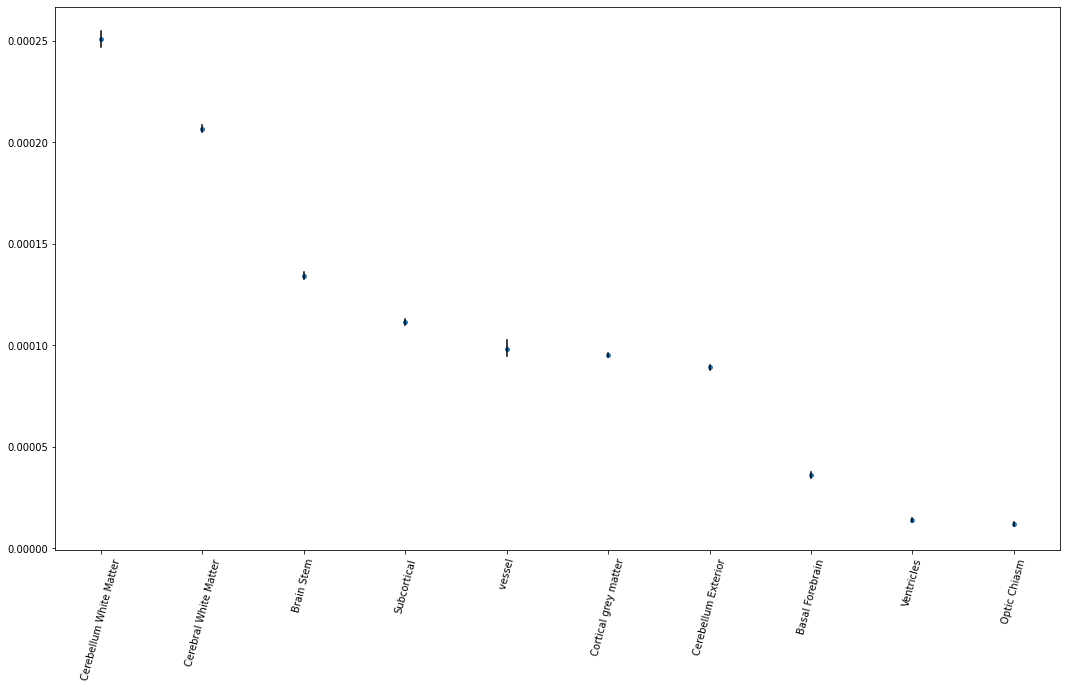

In [76]:
# bootstrap plot for global areas
fig = plt.figure(figsize=(18, 10))
plt.scatter(range(10),global_bs['mean'], s =15)
for i in range(10):
    plt.plot([i, i], [global_bs['low CI95'][i], global_bs['high CI95'][i]], color = 'black')

x_values = [' Cerebellum White Matter', ' Cerebral White Matter', 'Brain Stem',
       'Subcortical', ' vessel', 'Cortical grey matter',
       ' Cerebellum Exterior', 'Basal Forebrain', 'Ventricles',
       'Optic Chiasm']
x_axis = np.arange(0, 10, 1)

plt.xticks(x_axis, x_values, rotation = 75)
    
plt.show()

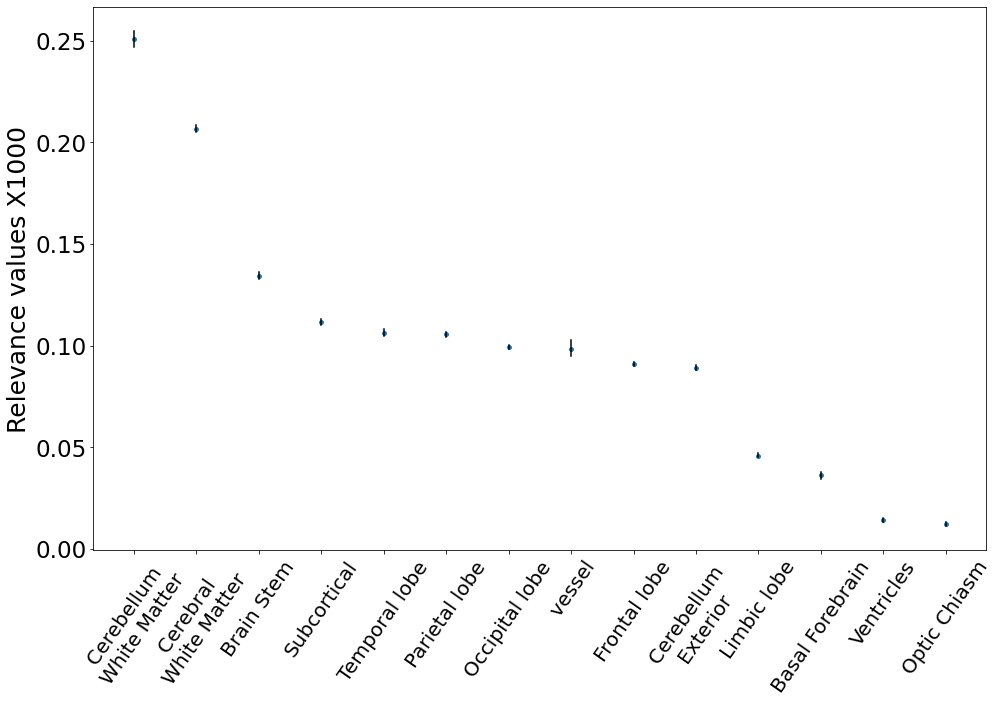

In [360]:
# bootstrap plot for local areas
fig = plt.figure(figsize=(16, 10))
plt.scatter(range(14),local_bs['mean']*1000, s =15)
for i in range(14):
    plt.plot([i, i], [local_bs['low CI95'][i]*1000, local_bs['high CI95'][i]*1000], color = 'black')

x_values = [' Cerebellum \nWhite Matter', ' Cerebral \nWhite Matter', 'Brain Stem',
       'Subcortical', 'Temporal lobe', 'Parietal lobe', 'Occipital lobe',
       ' vessel', 'Frontal lobe', ' Cerebellum \nExterior', 'Limbic lobe',
       'Basal Forebrain', 'Ventricles', 'Optic Chiasm']
x_axis = np.arange(0, 14, 1)

plt.xticks(x_axis, x_values, rotation=55, fontsize=20)
plt.ylabel('Relevance values X1000', fontsize=25)
    
plt.show()
fig.savefig(date+'/local_areas_bootstrap_'+date+'.png')
fig.savefig(date+'/local_areas_bootstrap_'+date+'.svg', format="svg")

In [78]:
pet_bs.index

Index([' Cerebral White Matter', ' Cerebellum White Matter', 'Brain Stem',
       'Subcortical', ' vessel', 'Parietal lobe', 'Occipital lobe',
       'Frontal lobe', 'Temporal lobe', 'Limbic lobe', ' Cerebellum Exterior',
       'Basal Forebrain', 'Ventricles', 'Optic Chiasm'],
      dtype='object')

In [79]:
p = pet_bs.T[['Temporal lobe','Parietal lobe','Occipital lobe',
                    'Frontal lobe',' Cerebellum Exterior']].T.sort_values('low CI95', ascending=False)
r = local_bs.T[['Temporal lobe','Parietal lobe','Occipital lobe',
                    'Frontal lobe',' Cerebellum Exterior']].T.sort_values('low CI95', ascending=False)*1000

In [80]:
p

mean  low CI95  high CI95
Parietal lobe         1.448703  1.432741   1.466270
Occipital lobe        1.439993  1.425977   1.455320
Frontal lobe          1.435016  1.419632   1.451971
Temporal lobe         1.359168  1.344496   1.374531
 Cerebellum Exterior  1.135617  1.127730   1.143543

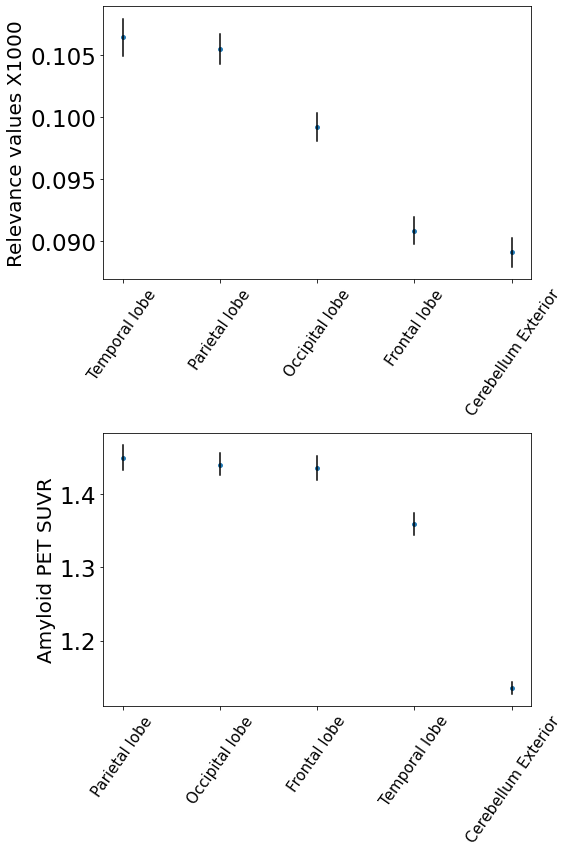

In [242]:

fig, ax = plt.subplots(2,1, figsize=(8,12))
plt.rcParams["figure.figsize"] = [7.50, 3.50]
ax[0].scatter(range(5),r['mean'], s =15)
for i in range(5):
    ax[0].plot([i, i], [r['low CI95'][i], r['high CI95'][i]], color = 'black')

x_values = r.index
x_axis = np.arange(0, 5, 1)

ax[0].set_xticks(x_axis, x_values, rotation=55, fontsize=15)
ax[0].set_ylabel('Relevance values X1000', fontsize=20)

ax[1].scatter(range(5),p['mean'], s =15)
for i in range(5):
    ax[1].plot([i, i], [p['low CI95'][i], p['high CI95'][i]], color = 'black')

x_values = p.index
x_axis = np.arange(0, 5, 1)

ax[1].set_xticks(x_axis, x_values, rotation=55, fontsize=15)
ax[1].set_ylabel('Amyloid PET SUVR', fontsize=20)

fig.tight_layout()
fig.savefig(date+'/gm_petrel_bootstrap_'+date+'.png')
fig.savefig(date+'/gm_petrel_bootstrap_'+date+'.svg', format="svg")

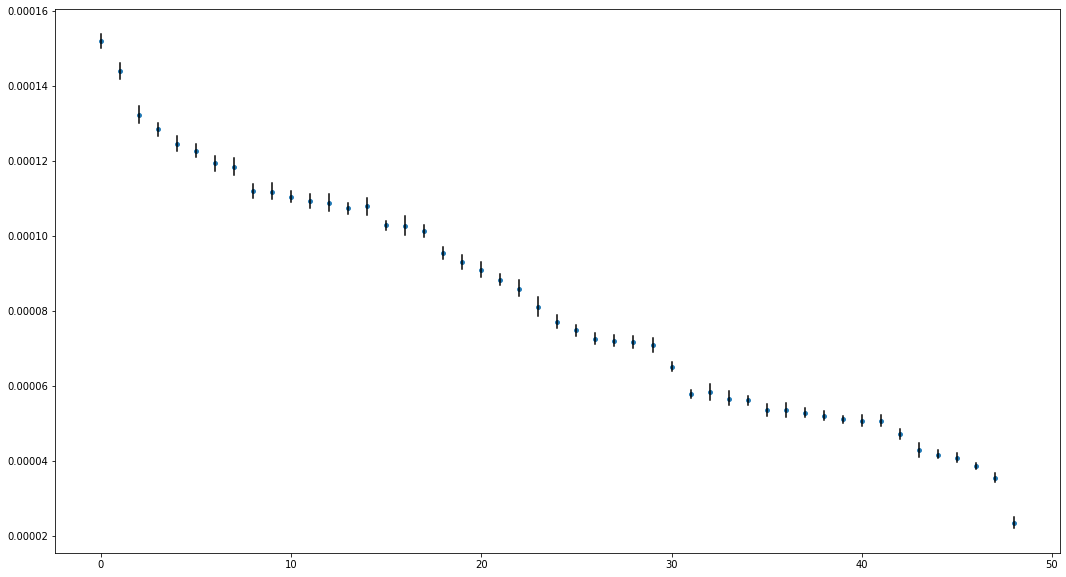

In [82]:
# bootstrap plot for GM areas only
fig = plt.figure(figsize=(18, 10))
plt.scatter(range(49),gm_only_bs['mean'], s =15)
for i in range(49):
    plt.plot([i, i], [gm_only_bs['low CI95'][i], gm_only_bs['high CI95'][i]], color = 'black')
plt.show()

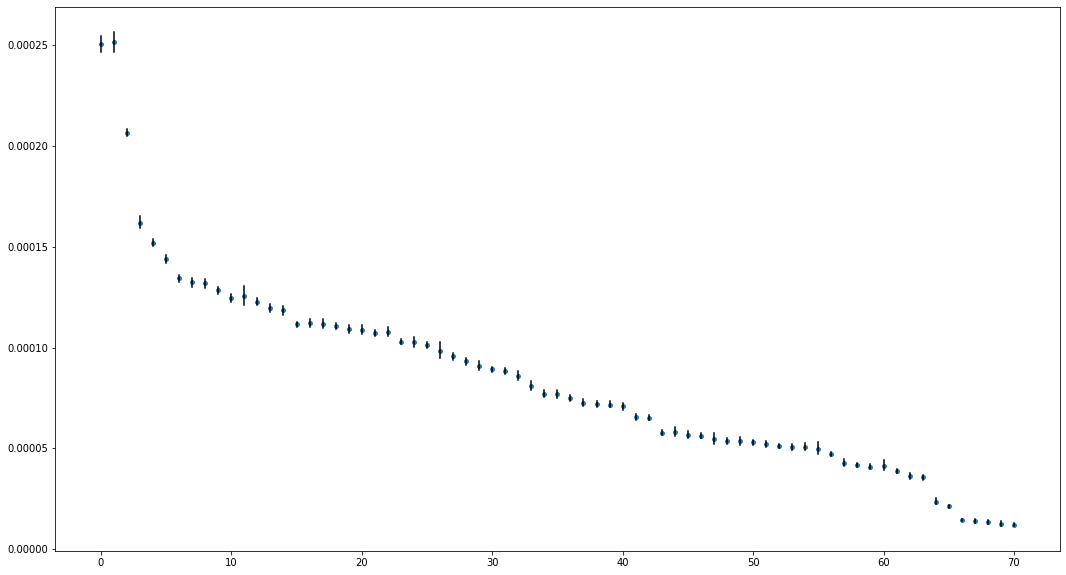

In [83]:
# bootstrap plot for detailed areas
fig = plt.figure(figsize=(18, 10))
plt.scatter(range(71),detailed_bs['mean'], s =15)
for i in range(71):
    plt.plot([i, i], [detailed_bs['low CI95'][i], detailed_bs['high CI95'][i]], color = 'black')
plt.show()

## Comparison of mean relevance per area between subclasses

In [84]:
local_bs

mean  low CI95  high CI95
 Cerebellum White Matter  0.000251  0.000247   0.000255
 Cerebral White Matter    0.000207  0.000205   0.000208
Brain Stem                0.000134  0.000133   0.000136
Subcortical               0.000112  0.000110   0.000113
Temporal lobe             0.000106  0.000105   0.000108
Parietal lobe             0.000105  0.000104   0.000107
Occipital lobe            0.000099  0.000098   0.000100
 vessel                   0.000098  0.000095   0.000103
Frontal lobe              0.000091  0.000090   0.000092
 Cerebellum Exterior      0.000089  0.000088   0.000090
Limbic lobe               0.000046  0.000045   0.000047
Basal Forebrain           0.000036  0.000034   0.000038
Ventricles                0.000014  0.000013   0.000015
Optic Chiasm              0.000012  0.000011   0.000013

In [85]:
local_bs_ad = bootstrapping_no_sorting(local_areas[local_areas.columns.intersection(id_ad)])*1000
local_bs_mci = bootstrapping_no_sorting(local_areas[local_areas.columns.intersection(id_mci)])*1000
local_bs_cn = bootstrapping_no_sorting(local_areas[local_areas.columns.intersection(id_cn)])*1000
local_bs_smc = bootstrapping_no_sorting(local_areas[local_areas.columns.intersection(id_smc)])*1000

local_bs_0 = bootstrapping_no_sorting(local_areas[local_areas.columns.intersection(bioid0)])*1000
local_bs_1 = bootstrapping_no_sorting(local_areas[local_areas.columns.intersection(bioid1)])*1000
local_bs_2 = bootstrapping_no_sorting(local_areas[local_areas.columns.intersection(bioid2)])*1000
local_bs_3 = bootstrapping_no_sorting(local_areas[local_areas.columns.intersection(bioid3)])*1000

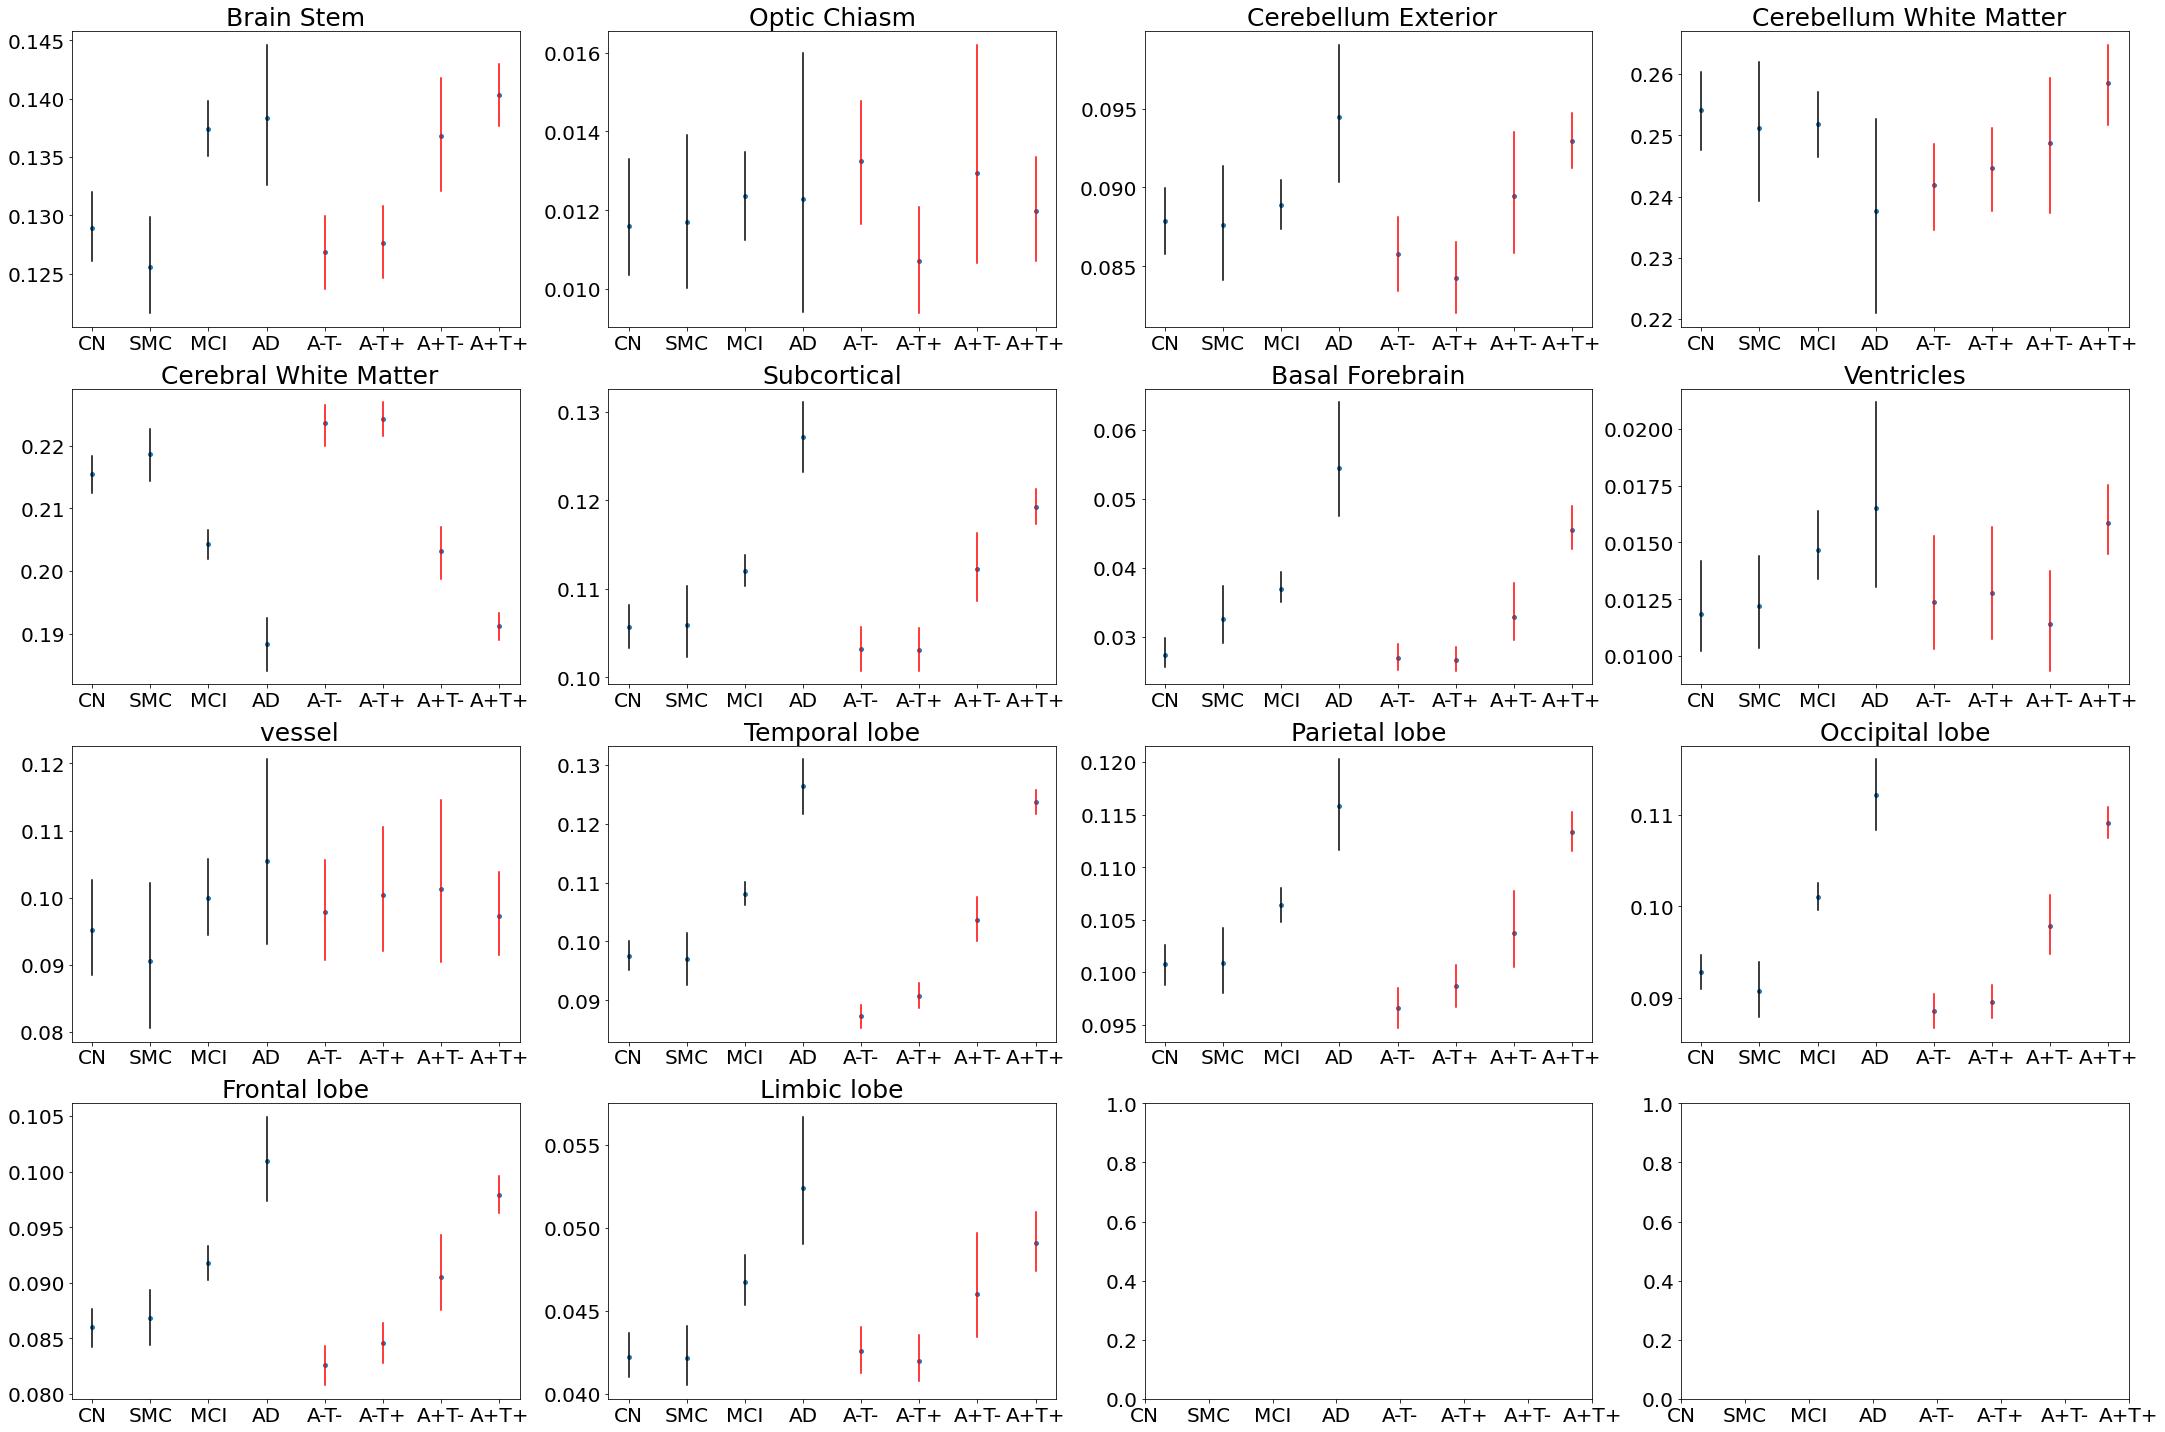

In [194]:
ncol = 4
nrow = math.ceil(local_bs.shape[0]/ncol)
fig, axes = plt.subplots(nrow,ncol, figsize=(30,20))
plt.rc('xtick', labelsize=23) 
plt.rc('ytick', labelsize=23) 
plt.setp(axes, xticks=range(8), xticklabels=['CN','SMC','MCI','AD','A-T-','A-T+','A+T-','A+T+'])
row = 0
col = 0

for i in range(local_bs.shape[0]):
#for i in range(1):

    axes[row,col].scatter(range(8),[local_bs_cn['mean'][i],local_bs_smc['mean'][i],
                                        local_bs_mci['mean'][i],local_bs_ad['mean'][i],
                                        local_bs_0['mean'][i],local_bs_1['mean'][i],
                                        local_bs_2['mean'][i],local_bs_3['mean'][i]], s =15)
    axes[row,col].plot([0, 0], [local_bs_cn['low CI95'][i], local_bs_cn['high CI95'][i]], color = 'black')
    axes[row,col].plot([1, 1], [local_bs_smc['low CI95'][i], local_bs_smc['high CI95'][i]], color = 'black')
    axes[row,col].plot([2, 2], [local_bs_mci['low CI95'][i], local_bs_mci['high CI95'][i]], color = 'black')
    axes[row,col].plot([3, 3], [local_bs_ad['low CI95'][i], local_bs_ad['high CI95'][i]], color = 'black')
    axes[row,col].plot([4, 4], [local_bs_0['low CI95'][i], local_bs_0['high CI95'][i]], color = 'red')
    axes[row,col].plot([5, 5], [local_bs_1['low CI95'][i], local_bs_1['high CI95'][i]], color = 'red')
    axes[row,col].plot([6, 6], [local_bs_2['low CI95'][i], local_bs_2['high CI95'][i]], color = 'red')
    axes[row,col].plot([7, 7], [local_bs_3['low CI95'][i], local_bs_3['high CI95'][i]], color = 'red')
    
    #x_values = ['AD','MCI','CN','SMC']
    #axes[row,col].set_xticklabels( range(4),x_values)
    axes[row,col].set_title(local_bs_ad.index[i], fontsize = 25)
    #print(row)
    #print(col)
    if col in (3,7,11,15,19):
        row = row +1
        col = 0
    else: col = col + 1
    
plt.tight_layout()
fig.savefig(date+'/rel_subclasses_'+date+'.png')
fig.savefig(date+'/rel_subclasses_'+date+'.svg', format="svg")

In [88]:
d = {'CN': local_bs_cn['mean'], 'SMC': local_bs_smc['mean'],
     'MCI': local_bs_mci['mean'],'AD': local_bs_ad['mean']}
classes_means = pd.DataFrame(data=d)

d = {'A-T-': local_bs_0['mean'],'A-T+': local_bs_1['mean'],
    'A+T-': local_bs_2['mean'],'A+T+': local_bs_3['mean'] }
bioclasses_means = pd.DataFrame(data=d)

In [89]:
classes_means.index

Index(['Brain Stem', 'Optic Chiasm', ' Cerebellum Exterior',
       ' Cerebellum White Matter', ' Cerebral White Matter', 'Subcortical',
       'Basal Forebrain', 'Ventricles', ' vessel', 'Temporal lobe',
       'Parietal lobe', 'Occipital lobe', 'Frontal lobe', 'Limbic lobe'],
      dtype='object')

In [90]:
cl_x = classes_means.T[[' Cerebellum Exterior','Temporal lobe',
       'Parietal lobe', 'Occipital lobe', 'Frontal lobe']].T
bio_x = bioclasses_means.T[[' Cerebellum Exterior','Temporal lobe',
       'Parietal lobe', 'Occipital lobe', 'Frontal lobe']].T

In [97]:
cl_x

CN       SMC       MCI        AD
 Cerebellum Exterior  0.087879  0.087627  0.088901  0.094451
Temporal lobe         0.097563  0.096946  0.108143  0.126413
Parietal lobe         0.100793  0.100904  0.106377  0.115783
Occipital lobe        0.092834  0.090784  0.101050  0.112257
Frontal lobe          0.086015  0.086870  0.091765  0.100962

In [101]:
local_bs_cn.index

Index(['Brain Stem', 'Optic Chiasm', ' Cerebellum Exterior',
       ' Cerebellum White Matter', ' Cerebral White Matter', 'Subcortical',
       'Basal Forebrain', 'Ventricles', ' vessel', 'Temporal lobe',
       'Parietal lobe', 'Occipital lobe', 'Frontal lobe', 'Limbic lobe'],
      dtype='object')

In [138]:
from cycler import cycler

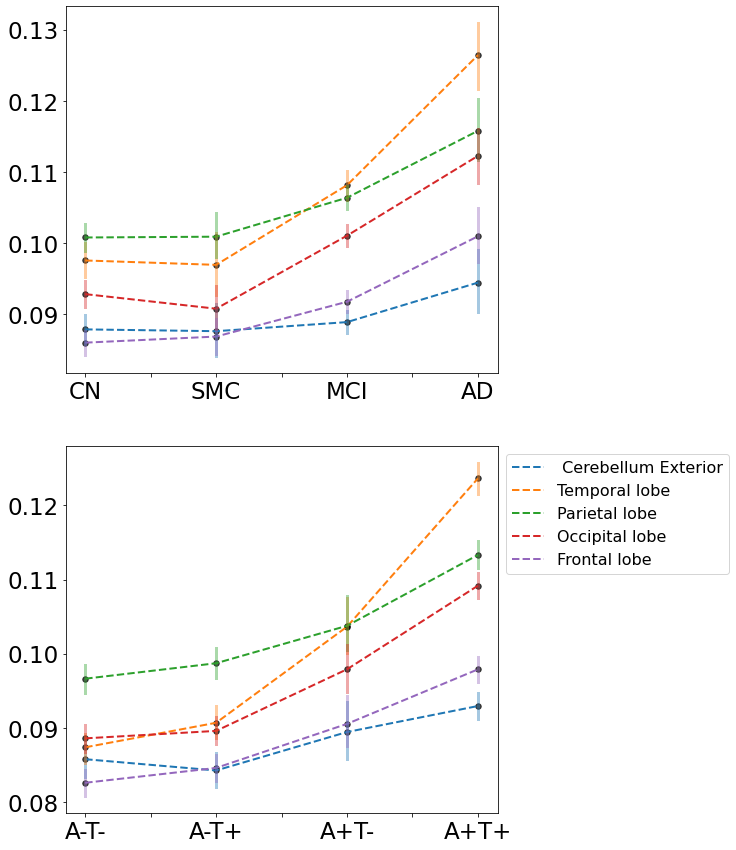

<Figure size 540x252 with 0 Axes>

In [215]:
# Cortical lobes and Cerebellum GM only
fig, axes = plt.subplots(2,1, figsize=(12,16))
new_prop_cycle = cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.rc('axes', prop_cycle=new_prop_cycle)
plt.rcParams["figure.figsize"] = [7.50, 3.50]
cl_x.T.plot.line(ax=axes[0],ls = '--',legend=None, linewidth=2)

def plt_bootstrap (axes_n, x_coordinate, data):
    axes[axes_n].scatter([x_coordinate,x_coordinate,x_coordinate,x_coordinate,x_coordinate],
                         data['mean']
                    [[' Cerebellum Exterior','Temporal lobe','Parietal lobe', 'Occipital lobe', 'Frontal lobe']].values,
                    s =30, color = 'black', alpha = 0.7)
    axes[axes_n].plot([x_coordinate, x_coordinate], 
                      [data['low CI95'][[' Cerebellum Exterior','Temporal lobe','Parietal lobe', 'Occipital lobe', 'Frontal lobe']].values,
                          data['high CI95'][[' Cerebellum Exterior','Temporal lobe','Parietal lobe', 'Occipital lobe', 'Frontal lobe']].values],
                  alpha = 0.4, linewidth=3)

plt_bootstrap(0,0,local_bs_cn)
plt_bootstrap(0,1,local_bs_smc)
plt_bootstrap(0,2,local_bs_mci)
plt_bootstrap(0,3,local_bs_ad)

#df2.plot(legend=None)
bio_x.T.plot.line(ax=axes[1], linewidth=2,ls = '--')
plt_bootstrap(1,0,local_bs_0)
plt_bootstrap(1,1,local_bs_1)
plt_bootstrap(1,2,local_bs_2)
plt_bootstrap(1,3,local_bs_3)

plt.legend(bbox_to_anchor=(1.0, 1.0), prop={'size': 16})
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.6, top=0.8)
plt.show()
    
plt.tight_layout()
fig.savefig(date+'/gm_rel_lines_'+date+'.png')
fig.savefig(date+'/gm_rel_lines_'+date+'.svg', format="svg")

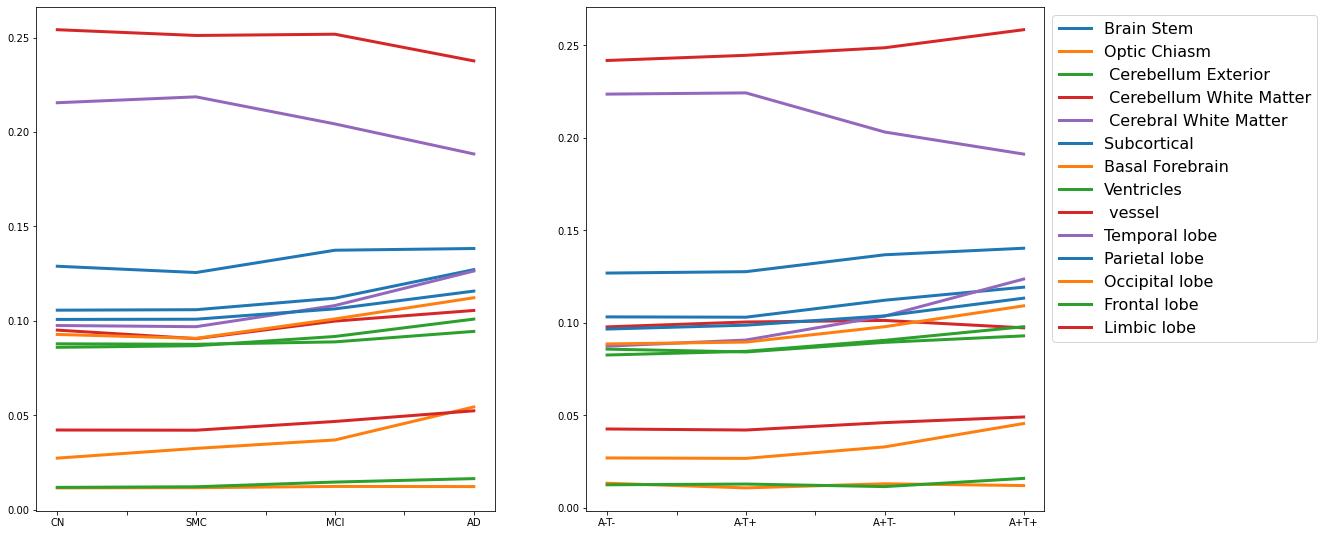

In [161]:
# all areas
fig, axes = plt.subplots(1,2, figsize=(20,10))
plt.rcParams["figure.figsize"] = [7.50, 3.50]
classes_means.T.plot.line(ax=axes[0],legend=None, linewidth=3)
#df2.plot(legend=None)
bioclasses_means.T.plot.line(ax=axes[1], linewidth=3)
plt.legend(bbox_to_anchor=(1.0, 1.0), prop={'size': 16})
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.8, top=0.8)
plt.show()

## Relevance values t-test & FDR correction

In [348]:

classes_means_stat = pd.DataFrame()
for i in local_areas.index:
    classes_means_stat.loc[i,'ad_vs_cn'] = scipy.stats.ttest_ind(local_areas[local_areas.columns.intersection(id_ad)].loc[i,:], 
                                                  local_areas[local_areas.columns.intersection(id_cn)].loc[i,:], 
                                                  equal_var=False)[1]
    
    classes_means_stat.loc[i,'mci_vs_cn'] = scipy.stats.ttest_ind(local_areas[local_areas.columns.intersection(id_mci)].loc[i,:], 
                                                  local_areas[local_areas.columns.intersection(id_cn)].loc[i,:], 
                                                  equal_var=False)[1]
    
    classes_means_stat.loc[i,'smc_vs_cn'] = scipy.stats.ttest_ind(local_areas[local_areas.columns.intersection(id_smc)].loc[i,:], 
                                                  local_areas[local_areas.columns.intersection(id_cn)].loc[i,:], 
                                                  equal_var=False)[1]
    
 


In [349]:
st_melt_cl = pd.melt(classes_means_stat.reset_index(),id_vars=['index'])
st_melt_cl['value'] = statsmodels.stats.multitest.multipletests(st_melt_cl['value'], alpha=0.05, method='fdr_bh')[1]
st_unmelted_cl = st_melt_cl.pivot(index='index', columns='variable')
st_unmelted_cl_adj = st_unmelted_cl[st_unmelted_cl<=0.01]
#.dropna(thresh=1)
#st_unmelted_cl_adj = st_unmelted_cl[st_unmelted_cl<=0.05]

In [350]:
bioclasses_means_stat = pd.DataFrame()
for i in local_areas.index:
    bioclasses_means_stat.loc[i,'A+T+_vs_A-T-'] = scipy.stats.ttest_ind(local_areas[local_areas.columns.intersection(bioid3)].loc[i,:], 
                                                  local_areas[local_areas.columns.intersection(bioid0)].loc[i,:], 
                                                  equal_var=False)[1]
    
    bioclasses_means_stat.loc[i,'A+T-_vs_A-T-'] = scipy.stats.ttest_ind(local_areas[local_areas.columns.intersection(bioid2)].loc[i,:], 
                                                  local_areas[local_areas.columns.intersection(bioid0)].loc[i,:], 
                                                  equal_var=False)[1]
    
    bioclasses_means_stat.loc[i,'A-T+_vs_A-T-'] = scipy.stats.ttest_ind(local_areas[local_areas.columns.intersection(bioid1)].loc[i,:], 
                                                  local_areas[local_areas.columns.intersection(bioid0)].loc[i,:], 
                                                  equal_var=False)[1]

In [351]:
biost_melt_cl = pd.melt(bioclasses_means_stat.reset_index(),id_vars=['index'])
biost_melt_cl['value'] = statsmodels.stats.multitest.multipletests(biost_melt_cl['value'], alpha=0.05, method='fdr_bh')[1]
biost_unmelted_cl = biost_melt_cl.pivot(index='index', columns='variable')
biost_unmelted_cl_adj = biost_unmelted_cl[biost_unmelted_cl<=0.01]
#.dropna(thresh=1)


In [353]:
st_unmelted_cl_adj

value                        
variable                      ad_vs_cn     mci_vs_cn smc_vs_cn
index                                                         
 Cerebellum Exterior               NaN           NaN       NaN
 Cerebellum White Matter           NaN           NaN       NaN
 Cerebral White Matter    3.996682e-20  2.942932e-08       NaN
 vessel                            NaN           NaN       NaN
Basal Forebrain           6.567611e-09  5.362875e-09       NaN
Brain Stem                         NaN  4.133626e-05       NaN
Frontal lobe              3.378476e-10  4.184155e-06       NaN
Limbic lobe               5.271001e-06  2.335227e-05       NaN
Occipital lobe            3.853489e-15  3.936434e-10       NaN
Optic Chiasm                       NaN           NaN       NaN
Parietal lobe             9.558050e-09  3.551351e-05       NaN
Subcortical               4.433962e-16  9.215117e-05       NaN
Temporal lobe             3.333153e-21  4.192974e-10       NaN
Ventricles                         NaN           NaN       NaN

In [324]:
biost_unmelted_cl_adj

value                           
variable                   A+T+_vs_A-T-  A+T-_vs_A-T- A-T+_vs_A-T-
index                                                             
 Cerebellum Exterior       1.008466e-05           NaN          NaN
 Cerebellum White Matter   1.797705e-03           NaN          NaN
 Cerebral White Matter     1.722682e-48  2.151999e-12          NaN
 vessel                             NaN           NaN          NaN
Basal Forebrain            1.545335e-21           NaN          NaN
Brain Stem                 2.108392e-09  2.194124e-03          NaN
Frontal lobe               7.759067e-31  1.538641e-04          NaN
Limbic lobe                9.371416e-08           NaN          NaN
Occipital lobe             1.722682e-48  4.793427e-06          NaN
Optic Chiasm                        NaN           NaN          NaN
Parietal lobe              6.499556e-31  1.767324e-03          NaN
Subcortical                1.952453e-20  5.352534e-04          NaN
Temporal lobe             6.445876e-102  1.990968e-12          NaN
Ventricles                          NaN           NaN          NaN

In [337]:
var(local_areas[local_areas.columns.intersection(bioid0)].loc[i,:], ddof=1)

1.5290602227176948e-10

In [331]:


#source of function https://machinelearningmastery.com/effect-size-measures-in-python/ 
def cohend(d1, d2):
 # calculate the size of samples
 n1, n2 = len(d1), len(d2)
 # calculate the variance of the samples
 s1, s2 = var(d1, ddof=1), var(d2, ddof=1)

# calculate the pooled standard deviation
#Where s is the pooled standard deviation, n1 and n2 are the size of the first sample 
#and second samples and s1 and s2 is the variance for the first and second samples. 
#The subtractions are the adjustments for the number of degrees of freedom.
 s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
 # calculate the means of the samples
 u1, u2 = np.mean(d1), np.mean(d2)
 # calculate the effect size
 return (u1 - u2) / s

In [338]:
classes_cohend = pd.DataFrame()
for i in local_areas.index:
    classes_cohend.loc[i,'ad_vs_cn'] = cohend(local_areas[local_areas.columns.intersection(id_ad)].loc[i,:], 
                                                  local_areas[local_areas.columns.intersection(id_cn)].loc[i,:])
    
    classes_cohend.loc[i,'mci_vs_cn'] = cohend(local_areas[local_areas.columns.intersection(id_mci)].loc[i,:], 
                                                  local_areas[local_areas.columns.intersection(id_cn)].loc[i,:])
    
    classes_cohend.loc[i,'smc_vs_cn'] = cohend(local_areas[local_areas.columns.intersection(id_smc)].loc[i,:], 
                                                  local_areas[local_areas.columns.intersection(id_cn)].loc[i,:])



In [339]:
classes_cohend

ad_vs_cn  mci_vs_cn  smc_vs_cn
Brain Stem                0.298199   0.265666  -0.120624
Optic Chiasm              0.043541   0.050600   0.007983
 Cerebellum Exterior      0.294393   0.047239  -0.012377
 Cerebellum White Matter -0.222128  -0.033865  -0.048974
 Cerebral White Matter   -0.975740  -0.358394   0.113867
Subcortical               0.908882   0.259966   0.010803
Basal Forebrain           0.840272   0.344243   0.242128
Ventricles                0.227486   0.141625   0.019801
 vessel                   0.141103   0.062284  -0.067408
Temporal lobe             1.169250   0.392802  -0.026012
Parietal lobe             0.712344   0.259364   0.006202
Occipital lobe            0.969567   0.400480  -0.114938
Frontal lobe              0.784775   0.287622   0.053425
Limbic lobe               0.610487   0.242828  -0.008483

In [332]:
bioclasses_cohend = pd.DataFrame()
for i in local_areas.index:
    bioclasses_cohend.loc[i,'A+T+_vs_A-T-'] = cohend(local_areas[local_areas.columns.intersection(bioid3)].loc[i,:], 
                                                  local_areas[local_areas.columns.intersection(bioid0)].loc[i,:])
    
    bioclasses_cohend.loc[i,'A+T-_vs_A-T-'] = cohend(local_areas[local_areas.columns.intersection(bioid2)].loc[i,:], 
                                                  local_areas[local_areas.columns.intersection(bioid0)].loc[i,:])
    
    bioclasses_cohend.loc[i,'A-T+_vs_A-T-'] = cohend(local_areas[local_areas.columns.intersection(bioid1)].loc[i,:], 
                                                  local_areas[local_areas.columns.intersection(bioid0)].loc[i,:])

In [333]:
bioclasses_cohend

A+T+_vs_A-T-  A+T-_vs_A-T-  A-T+_vs_A-T-
Brain Stem                    0.405996      0.337370      0.027220
Optic Chiasm                 -0.078693     -0.019720     -0.193581
 Cerebellum Exterior          0.320825      0.162092     -0.073295
 Cerebellum White Matter      0.214148      0.104422      0.045312
 Cerebral White Matter       -1.138217     -0.719964      0.024885
Subcortical                   0.649540      0.382567     -0.007586
Basal Forebrain               0.542096      0.296852     -0.014691
Ventricles                    0.169834     -0.049869      0.018420
 vessel                      -0.007024      0.049109      0.035796
Temporal lobe                 1.492532      0.830648      0.184224
Parietal lobe                 0.763764      0.371182      0.121331
Occipital lobe                1.017216      0.513901      0.060887
Frontal lobe                  0.761471      0.446381      0.127817
Limbic lobe                   0.320624      0.230476     -0.046900

## Amyloid concentration on PET scans t-test & FDG analysis  

In [204]:
pet_regions_means = pd.DataFrame()
pet_regions_means['CN'] = np.mean(local_areas_pet[local_areas_pet.columns.intersection(id_cn)], axis = 1)
pet_regions_means['SMC'] = np.mean(local_areas_pet[local_areas_pet.columns.intersection(id_smc)], axis = 1)
pet_regions_means['MCI'] = np.mean(local_areas_pet[local_areas_pet.columns.intersection(id_mci)], axis = 1)
pet_regions_means['AD'] = np.mean(local_areas_pet[local_areas_pet.columns.intersection(id_ad)], axis = 1)

pet_regions_biomeans = pd.DataFrame()
pet_regions_biomeans['A-T-'] = np.mean(local_areas_pet[local_areas_pet.columns.intersection(bioid0)], axis = 1)
pet_regions_biomeans['A-T+'] = np.mean(local_areas_pet[local_areas_pet.columns.intersection(bioid1)], axis = 1)
pet_regions_biomeans['A+T-'] = np.mean(local_areas_pet[local_areas_pet.columns.intersection(bioid2)], axis = 1)
pet_regions_biomeans['A+T+'] = np.mean(local_areas_pet[local_areas_pet.columns.intersection(bioid3)], axis = 1)

pet_regions_means = pet_regions_means.T[[' vessel',' Cerebellum White Matter', ' Cerebral White Matter',
                                       'Optic Chiasm','Ventricles',
                                       'Brain Stem', 'Subcortical',#' Hippocampus',
                                       'Temporal lobe','Parietal lobe','Occipital lobe','Frontal lobe',' Cerebellum Exterior',
                                      'Basal Forebrain','Limbic lobe']].T
pet_regions_biomeans = pet_regions_biomeans.T[[' vessel',' Cerebellum White Matter', ' Cerebral White Matter',
                                       'Optic Chiasm','Ventricles',
                                       'Brain Stem', 'Subcortical',#' Hippocampus',
                                       'Temporal lobe','Parietal lobe','Occipital lobe','Frontal lobe',' Cerebellum Exterior',
                                      'Basal Forebrain','Limbic lobe']].T



In [205]:
classes_means_stat = pd.DataFrame()
for i in local_areas_pet.index:
    classes_means_stat.loc[i,'ad_vs_cn'] = scipy.stats.ttest_ind(local_areas_pet[local_areas_pet.columns.intersection(id_ad)].loc[i,:], 
                                                  local_areas_pet[local_areas_pet.columns.intersection(id_cn)].loc[i,:], 
                                                  equal_var=False)[1]
    
    classes_means_stat.loc[i,'mci_vs_cn'] = scipy.stats.ttest_ind(local_areas_pet[local_areas_pet.columns.intersection(id_mci)].loc[i,:], 
                                                  local_areas_pet[local_areas_pet.columns.intersection(id_cn)].loc[i,:], 
                                                  equal_var=False)[1]
    
    classes_means_stat.loc[i,'smc_vs_cn'] = scipy.stats.ttest_ind(local_areas_pet[local_areas_pet.columns.intersection(id_smc)].loc[i,:], 
                                                  local_areas_pet[local_areas_pet.columns.intersection(id_cn)].loc[i,:], 
                                                  equal_var=False)[1]
    

In [206]:
st_melt_cl = pd.melt(classes_means_stat.reset_index(),id_vars=['index'])
st_melt_cl['value'] = statsmodels.stats.multitest.multipletests(st_melt_cl['value'], alpha=0.05, method='fdr_bh')[1]
st_unmelted_cl = st_melt_cl.pivot(index='index', columns='variable')
st_unmelted_cl_adj = st_unmelted_cl[st_unmelted_cl<=0.01]

In [207]:
st_unmelted_cl_adj

value                    
variable                      ad_vs_cn mci_vs_cn smc_vs_cn
index                                                     
 Cerebellum Exterior      2.622061e-05       NaN       NaN
 Cerebellum White Matter  7.711094e-08  0.000350       NaN
 Cerebral White Matter             NaN       NaN       NaN
 vessel                   3.119115e-05       NaN       NaN
Basal Forebrain           7.445096e-10  0.001878       NaN
Brain Stem                4.149147e-06  0.002792       NaN
Frontal lobe              2.294683e-11  0.000865       NaN
Limbic lobe               4.914939e-12  0.000183       NaN
Occipital lobe            1.374464e-13  0.002243       NaN
Optic Chiasm                       NaN       NaN       NaN
Parietal lobe             1.633309e-12  0.000350       NaN
Subcortical                        NaN       NaN       NaN
Temporal lobe             1.633309e-12  0.001062       NaN
Ventricles                         NaN       NaN       NaN

In [208]:
bioclasses_means_stat = pd.DataFrame()
for i in local_areas_pet.index:
    bioclasses_means_stat.loc[i,'A+T+_vs_A-T-'] = scipy.stats.ttest_ind(local_areas_pet[local_areas_pet.columns.intersection(bioid3)].loc[i,:], 
                                                  local_areas_pet[local_areas_pet.columns.intersection(bioid0)].loc[i,:], 
                                                  equal_var=False)[1]
    
    bioclasses_means_stat.loc[i,'A+T-_vs_A-T-'] = scipy.stats.ttest_ind(local_areas_pet[local_areas_pet.columns.intersection(bioid2)].loc[i,:], 
                                                  local_areas_pet[local_areas_pet.columns.intersection(bioid0)].loc[i,:], 
                                                  equal_var=False)[1]
    
    bioclasses_means_stat.loc[i,'A-T+_vs_A-T-'] = scipy.stats.ttest_ind(local_areas_pet[local_areas_pet.columns.intersection(bioid1)].loc[i,:], 
                                                  local_areas_pet[local_areas_pet.columns.intersection(bioid0)].loc[i,:], 
                                                  equal_var=False)[1]

In [209]:
biost_melt_cl = pd.melt(bioclasses_means_stat.reset_index(),id_vars=['index'])
biost_melt_cl['value'] = statsmodels.stats.multitest.multipletests(biost_melt_cl['value'], alpha=0.05, method='fdr_bh')[1]
biost_unmelted_cl = biost_melt_cl.pivot(index='index', columns='variable')
biost_unmelted_cl_adj = biost_unmelted_cl[biost_unmelted_cl<=0.01]

In [210]:
biost_unmelted_cl_adj

value                           
variable                   A+T+_vs_A-T-  A+T-_vs_A-T- A-T+_vs_A-T-
index                                                             
 Cerebellum Exterior       9.717008e-24  5.710050e-06          NaN
 Cerebellum White Matter            NaN           NaN          NaN
 Cerebral White Matter     2.409269e-15  8.368242e-03          NaN
 vessel                    4.324137e-28  1.260440e-06          NaN
Basal Forebrain            2.825713e-60  2.481190e-08          NaN
Brain Stem                 1.698400e-04           NaN          NaN
Frontal lobe               4.361193e-88  7.979647e-15     0.006918
Limbic lobe               5.675741e-109  8.472570e-17     0.008657
Occipital lobe             5.628056e-92  6.496563e-16     0.006529
Optic Chiasm                        NaN           NaN          NaN
Parietal lobe              1.288823e-97  1.092923e-15          NaN
Subcortical                1.963007e-32  5.137598e-06          NaN
Temporal lobe             2.251158e-102  3.762686e-16     0.001514
Ventricles                 4.956023e-08           NaN     0.008990

In [212]:
pet_regions_means

CN       SMC       MCI        AD
 vessel                   1.429928  1.390949  1.449558  1.546220
 Cerebellum White Matter  1.851870  1.794680  1.776767  1.684106
 Cerebral White Matter    1.933531  1.912833  1.905446  1.931659
Optic Chiasm              0.777151  0.777953  0.775820  0.770454
Ventricles                0.838886  0.838061  0.862768  0.841375
Brain Stem                1.719008  1.664287  1.666786  1.607117
Subcortical               1.473565  1.439550  1.477359  1.509147
Temporal lobe             1.302819  1.289471  1.367273  1.509993
Parietal lobe             1.378015  1.384609  1.459222  1.615897
Occipital lobe            1.383360  1.377805  1.443638  1.607564
Frontal lobe              1.371225  1.382118  1.443609  1.586164
 Cerebellum Exterior      1.121974  1.114939  1.134254  1.192278
Basal Forebrain           1.038791  1.039156  1.091940  1.207620
Limbic lobe               1.248057  1.239129  1.323878  1.456508

In [213]:
linestyle = ['--','--','--','-.','-.',':',':','-','-','-','-','-','s-','s-']
c = ['#1F77B4','#AEC7E8','#FF7F0E','#FFBB78','#2CA02C','#98DF8A','#D62728','#FF9896',
'#9467BD','#C5B0D5','#8C564B','#C49C94','#E377C2','#F7B6D2','#7F7F7F','#C7C7C7','#BCBD22',
'#DBDB8D','#17BECF','#9EDAE5']
cb = ['#000000','#E69F00','#56B4E9','#009E73','#F0E442','#0072B2','#D55E00','#CC79A7']
c2 = ['#266489','#68B9C0','#90D585','#F3C151','#F37F64','#424856','#8F97A4','#DAC096','#76846E',
'#DABFAF','#A65B69','#97A69D']

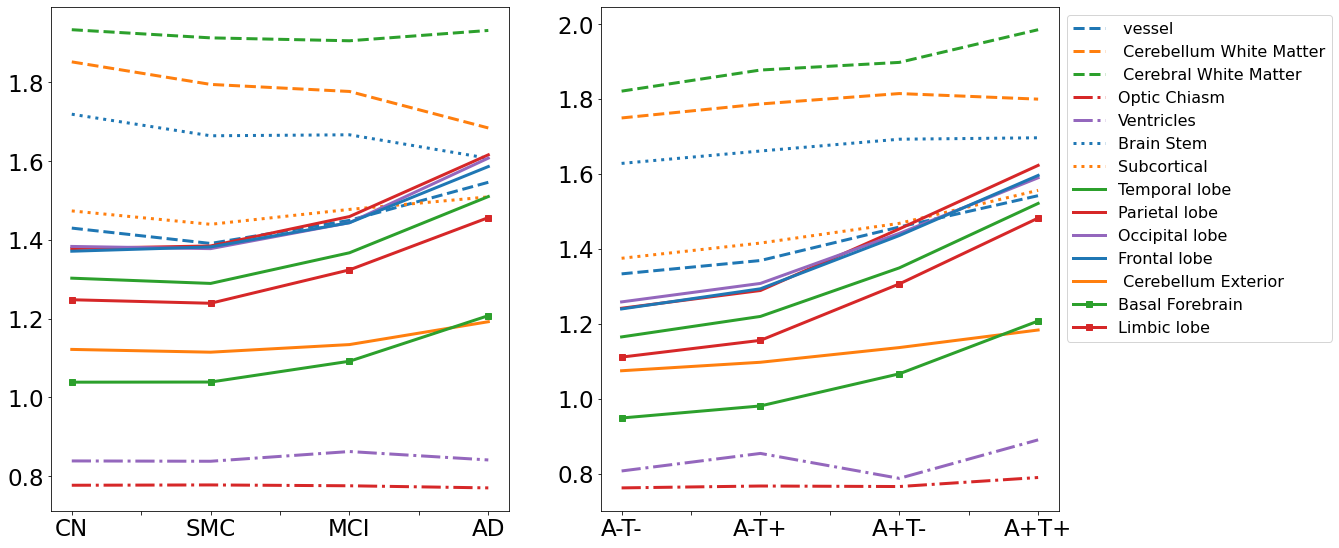

In [214]:
fig, axes = plt.subplots(1,2, figsize=(20,10))
plt.rcParams["figure.figsize"] = [7.50, 3.50]
pet_regions_means.T.plot.line(ax=axes[0],style=linestyle,legend=None, linewidth=3)
#df2.plot(legend=None)
pet_regions_biomeans.T.plot.line(ax=axes[1],style=linestyle, linewidth=3)
plt.legend(bbox_to_anchor=(1.0, 1.0), prop={'size': 16})
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.8, top=0.8)
plt.show()
fig.savefig(date+'/pet_concentration_all_'+date+'.png')
fig.savefig(date+'/pet_concentration_all_'+date+'.svg', format="svg")

In [66]:
pet_regions_biomeans = pet_regions_biomeans.T[['Brain Stem', 'Subcortical','Temporal lobe','Parietal lobe','Occipital lobe',
                    'Frontal lobe',' Cerebellum Exterior']]

In [67]:
pet_regions_biomeans

Brain Stem  Subcortical  Temporal lobe  Parietal lobe  Occipital lobe  \
A-T-    1.620040     1.367183       1.160185       1.236757        1.253581   
A-T+    1.651370     1.416329       1.248630       1.323743        1.338587   
A+T-    1.685450     1.438652       1.277871       1.374540        1.371713   
A+T+    1.687699     1.523054       1.447650       1.540976        1.520635   

      Frontal lobe   Cerebellum Exterior  
A-T-      1.233655              1.070683  
A-T+      1.323188              1.098629  
A+T-      1.366790              1.119195  
A+T+      1.521091              1.162230

<AxesSubplot:>

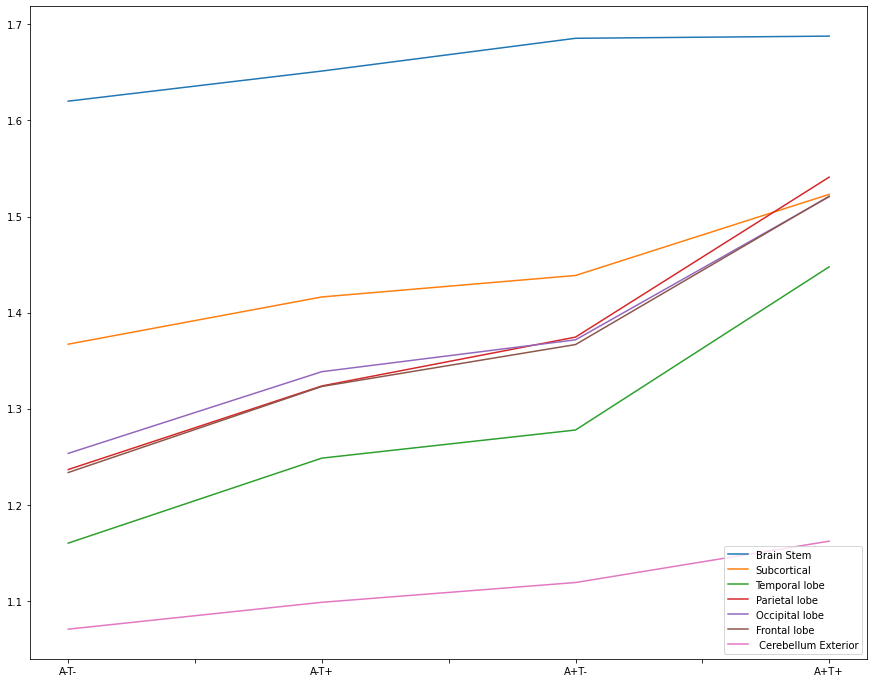

In [68]:
pet_regions_biomeans.plot.line(figsize=(15,12))

<AxesSubplot:>

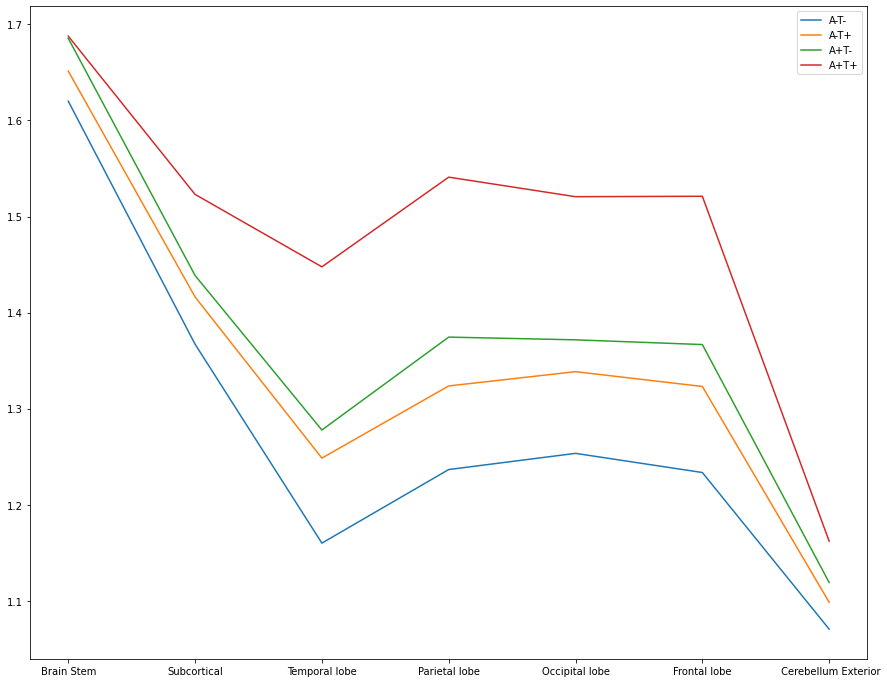

In [69]:
pet_regions_biomeans.T.plot.line(figsize=(15,12))

In [643]:
local_bs = local_bs*1000

In [660]:
local_bs

mean  low CI95  high CI95
 Cerebellum White Matter  0.252117  0.248202   0.255886
 Cerebral White Matter    0.206506  0.204768   0.208172
Brain Stem                0.134484  0.132870   0.136209
Subcortical               0.111505  0.110230   0.112862
Temporal lobe             0.106282  0.104805   0.107819
Parietal lobe             0.105303  0.104107   0.106529
Occipital lobe            0.099176  0.098035   0.100356
 vessel                   0.099025  0.094962   0.103303
Frontal lobe              0.090575  0.089482   0.091706
 Cerebellum Exterior      0.089019  0.087841   0.090183
Limbic lobe               0.045741  0.044782   0.046813
Basal Forebrain           0.035780  0.034282   0.037519
Ventricles                0.013696  0.012718   0.014790
Optic Chiasm              0.012344  0.011514   0.013499

In [605]:
# Is the difference between lobes' means significant?
print(scipy.stats.ttest_ind(local_areas.loc['Temporal lobe'],local_areas.loc['Parietal lobe'], 
                                                  equal_var=False))
print(scipy.stats.ttest_ind(local_areas.loc['Temporal lobe'],local_areas.loc['Occipital lobe'], 
                                                  equal_var=False))
print(scipy.stats.ttest_ind(local_areas.loc['Parietal lobe'],local_areas.loc['Occipital lobe'], 
                                                  equal_var=False))
print(scipy.stats.ttest_ind(local_areas.loc['Occipital lobe'],local_areas.loc['Frontal lobe'], 
                                                  equal_var=False))

Ttest_indResult(statistic=0.9929199774687535, pvalue=0.3208393453525574)
Ttest_indResult(statistic=7.362873894846358, pvalue=2.404241708265357e-13)
Ttest_indResult(statistic=7.197883042278331, pvalue=7.840802993740867e-13)
Ttest_indResult(statistic=10.587019215900364, pvalue=1.0514835735319574e-25)


## additional visualisation

In [745]:
# illustrate several regions together
x = brain_dict_merged[' Cerebral White Matter']+brain_dict_merged[' Cerebellum White Matter']
x = brain_dict_merged['Brain Stem']+brain_dict_merged['Subcortical']+brain_dict_merged['Frontal lobe']+brain_dict_merged['Parietal lobe']+brain_dict_merged['Occipital lobe']+brain_dict_merged['Temporal lobe']+brain_dict_merged[' Cerebellum Exterior']+brain_dict_merged[' vessel']
x = brain_dict_merged['Limbic lobe']+brain_dict_merged['Basal Forebrain']+brain_dict_merged['Ventricles']+brain_dict_merged['Optic Chiasm']

(-0.5, 196.5, 188.5, -0.5)

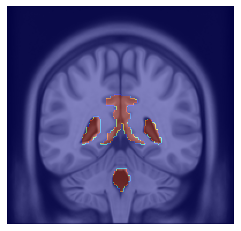

In [758]:
plt.imshow(np.rot90(mni_t1[:, 90, :].copy()), cmap = 'gray')
plt.imshow(np.rot90(x[:, 90, :].copy()), cmap = 'jet',alpha = 0.5) 
plt.axis('off')

(-0.5, 196.5, 188.5, -0.5)

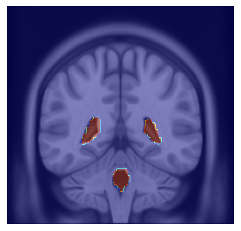

In [765]:
plt.imshow(np.rot90(mni_t1[:, 90, :].copy()), cmap = 'gray')
plt.imshow(np.rot90(brain_dict_merged['Ventricles'][:, 90, :].copy()), cmap = 'jet',alpha = 0.5) 
plt.axis('off')

# Highlight several brain regions on MNI with different colours

In [84]:
sig = {k: brain_dict_merged[k] for k in (' Pallidum',' Cerebellum White Matter',
                                    ' SPL superior parietal lobule',' Cerebral White Matter',
                               ' Ventral DC', ' Accumbens Area')}

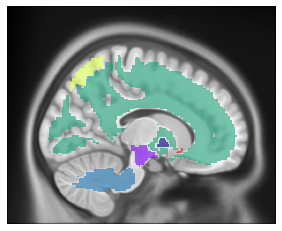

In [85]:
x = sig.copy()
for i in sig:
    #print(i)
    x[i] = np.where(sig[i] ==0 , np.nan, sig[i])

plt.imshow(np.rot90(mni_t1[85, :, :].copy()), cmap = 'gray') 
plt.imshow(np.rot90(x[' Pallidum'][85, :, :].copy()), interpolation=None, alpha = 0.6, cmap = 'jet' ),
plt.imshow(np.rot90(x[' Cerebellum White Matter'][85, :, :].copy()), interpolation=None, alpha = 0.6, cmap = 'tab10' )
plt.imshow(np.rot90(x[' SPL superior parietal lobule'][85, :, :].copy()), interpolation=None, alpha = 0.8 , cmap = 'Wistia' )
plt.imshow(np.rot90(x[' Cerebral White Matter'][85, :, :].copy()), interpolation=None, alpha = 0.6, cmap = 'Dark2' )
plt.imshow(np.rot90(x[' Ventral DC'][85, :, :].copy()), interpolation=None, alpha = 0.6, cmap = 'rainbow' )
plt.imshow(np.rot90(x[' Accumbens Area'][85, :, :].copy()), interpolation=None, alpha = 0.6, cmap = 'Set1' )
plt.axis('off')

plt.savefig(date+'/top5_brain_areas_'+date+'.png')
plt.savefig(date+'/top5_brain_areas_'+date+'.svg', format="svg")

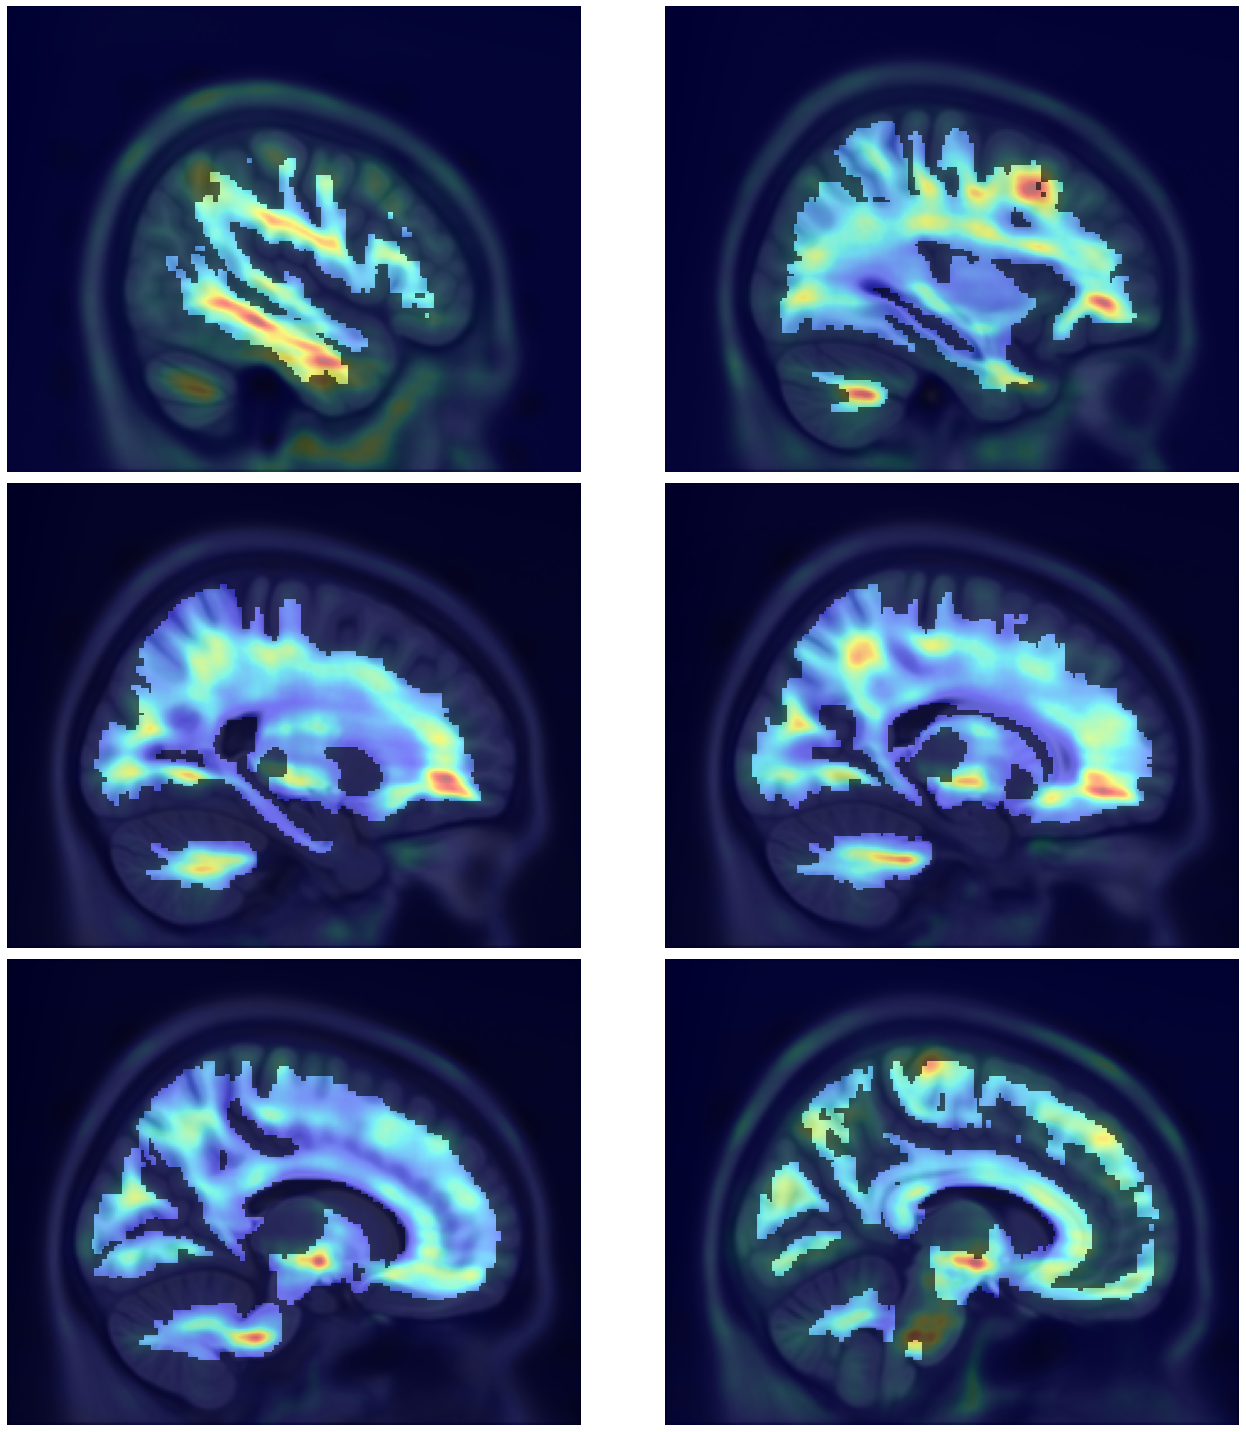

In [86]:
sig_merge = np.zeros([197, 233, 189],dtype = 'float64')
for i in sig:
    sig_merge = np.add(sig_merge,sig[i])
sig_merge = np.where(sig_merge ==1 , np.nan, sig_merge)
#num = np.shape(sig)[0]
#for i in sig:
    #print(i)
#    sig[i] = np.where(sig[i] ==1 , np.nan, sig[i])
    

fig, axes = plt.subplots(3,2, figsize=(20,20))
r = 0
c = 0
for idx,i in enumerate([50,65,75,80,85,90]):
    axes[r,c].imshow(np.rot90(mni_t1[i, :, :].copy()), cmap = 'gray') 
    axes[r,c].imshow(np.rot90(relevance_map['total_map'][i, :, :].copy()), interpolation=None, alpha = 0.5, cmap = 'jet' )
    axes[r,c].imshow(np.rot90(sig_merge[i, :, :].copy()), interpolation=None, alpha = 0.6, cmap = 'gray' )
    axes[r,c].axis('off')
    if idx%2==1:
        r += 1
        c -= 1
    else:
        c += 1
        
fig.tight_layout()        
fig.savefig(date+'/top5_brain_areas_slices_'+date+'.png')
fig.savefig(date+'/top5_brain_areas_slices_'+date+'.svg', format="svg")